 <font size="6"><b>Проект E-commerce — выявление профилей потребления</b></font><br />

**Описание данных:** 

Предоставленный датасет описывает транзакции интернет-магазина товаров для дома и быта **«Пока все ещё тут»**.

- `date` —  дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена заказа;

**Цель исследования** 

Провести исследовательский анализ, который поможет сделать сайт более персонифицированным и повысить доходы компании на основе выявления самых доходных групп товаров и клиентов, а также изучить сезонность спроса.


В проекте будут рассмотрены **2 профиля потребления во временном разрезе**:
    
* Товарный профиль
* Клиентский профиль


**План исследования**

**1. Предобработка данных:**
 - преобразование форматов
 - поиск явных и неявных дубликатов
 - поиск пропусков
 - поиск аномальных значений

**2. Исследовательский анализ**
 - добавление столбца чека каждого клиента
 - добавление столбца сезона
 - группировка товаров по категориям
    * исследование категорий (доходность, ассортимент, кол-во продаж)
    * исследование сезонности товаров
 - разбиение покупателей на группы лояльности с помощью RFM-анализа
    * исследование розничных и оптовых покупателей (кол-во покупателей, доходность абсолютная и средняя по чеку)
    * исследование сезонности доходов от групп покупателей

**3. Проверка гипотез**
 - Средние чеки разных кластеров товаров равны/не равны
 - помесячная выручка от оптовых клиентов выше/не выше, чем выручка от розничных клиентов

**4. Выводы и рекомендации**

## Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import matplotlib
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from datetime import date,timedelta
from pymystem3 import Mystem
from collections import Counter
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

In [2]:
data = pd.read_csv('/datasets/ecom_dataset_upd.csv')

## Посмотрим на данные

In [3]:
data.head(7)

date                           customer_id  order_id  \
0  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
5  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
6  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  
0    Комнатное растение в горшке Алое Вера, d12, h30         1  142.0  
1  Комнатное растение в горшке Кофе Арабика, d12,...         1  194.0  
2                        Радермахера d-12 см h-20 см         1  112.0  
3                   Хризолидокарпус Лутесценс d-9 см         1  179.0  
4                     Циперус Зумула d-12 см h-25 см         1  112.0  
5                            Шеффлера Лузеана d-9 см         1  164.0  
6                   Юкка нитчатая d-12 см h-25-35 см         1  134.0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


### Приведём `date` в человеческий формат, заодно уберём время покупки

In [5]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H').astype('datetime64[D]')

In [6]:
data.head(7)

date                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
5 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
6 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  
0    Комнатное растение в горшке Алое Вера, d12, h30         1  142.0  
1  Комнатное растение в горшке Кофе Арабика, d12,...         1  194.0  
2                        Радермахера d-12 см h-20 см         1  112.0  
3                   Хризолидокарпус Лутесценс d-9 см         1  179.0  
4                     Циперус Зумула d-12 см h-25 см         1  112.0  
5                            Шеффлера Лузеана d-9 см         1  164.0  
6                   Юкка нитчатая d-12 см h-25-35 см         1  134.0

### Переведём `product` в нижний регистр, для удобности дальнейшего анализа

In [7]:
data['product'] = data['product'].str.lower()

In [8]:
data.head(7)

date                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
5 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
6 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  
0    комнатное растение в горшке алое вера, d12, h30         1  142.0  
1  комнатное растение в горшке кофе арабика, d12,...         1  194.0  
2                        радермахера d-12 см h-20 см         1  112.0  
3                   хризолидокарпус лутесценс d-9 см         1  179.0  
4                     циперус зумула d-12 см h-25 см         1  112.0  
5                            шеффлера лузеана d-9 см         1  164.0  
6                   юкка нитчатая d-12 см h-25-35 см         1  134.0

### Преобразуем формат `price` - оставим только целую часть

In [9]:
data['price'] = data['price'].apply(int)

In [10]:
data.head(7)

date                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
5 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
6 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  
0    комнатное растение в горшке алое вера, d12, h30         1    142  
1  комнатное растение в горшке кофе арабика, d12,...         1    194  
2                        радермахера d-12 см h-20 см         1    112  
3                   хризолидокарпус лутесценс d-9 см         1    179  
4                     циперус зумула d-12 см h-25 см         1    112  
5                            шеффлера лузеана d-9 см         1    164  
6                   юкка нитчатая d-12 см h-25-35 см         1    134

## Посмотрим на дубликаты

### Явные дубликаты

In [11]:
data.duplicated().value_counts()

False    6508
True      966
dtype: int64

In [12]:
round((len(data)-len(data.drop_duplicates())) / len(data) * 100, 2)

12.92

**Посмотрим на кол-во заказов и клиентов до манипуляций с данными**

In [13]:
print('Количество заказов:', data['order_id'].nunique(), '\n' 'Количество клиентов:', data['customer_id'].nunique())

Количество заказов: 3521 
Количество клиентов: 2451


 <font size="2"><b>Удаляем дубликаты</b></font><br />

In [14]:
data = data.drop_duplicates(ignore_index=True)

### Неявные дубликаты

 <font size="2"><b>Отношение заказа к покупателю - один к одному</b></font><br />

In [15]:
tmp_data0 = data.groupby('order_id')['customer_id'].nunique().to_frame()
tmp_data0.rename(columns={'customer_id': 'cnt'}, inplace=True)

 <font size="2"><b>Заказы с несколькими покупателями</b></font><br />

In [16]:
tmp_data0[tmp_data0['cnt'] >= 2]

cnt
order_id     
14872       2
68785       2
69283       2
69310       2
69345       2
69410       2
69485       3
69531       2
69833       2
70114       2
70542       2
70631       2
70726       2
70808       2
70903       2
70946       2
71054       2
71226       2
71461       2
71480       3
71542       2
71571       2
71648       2
71663       2
72188       2
72778       2
72790       2
72845       4
72950       2

In [17]:
data[data['order_id'] == 70808]

date                           customer_id  order_id  \
2293 2019-03-20  78e8c0e7-4888-4a75-8137-a90f02a6cb8c     70808   
2294 2019-03-20  ad1630b2-fc36-4961-900a-46612ff6c655     70808   

                                                product  quantity  price  
2293  тележка багажная delta тбр-20 черный с серым г...         1    727  
2294  тележка багажная delta тбр-20 черный с серым г...         1    727

In [18]:
data[data['order_id'] == 72188]

date                           customer_id  order_id  \
5096 2019-08-02  da6f7bf7-f699-4046-a4dd-cab0c27debcb     72188   
5100 2019-08-03  55b8d928-77f8-40fc-a2e9-08424d13b0e4     72188   

                                   product  quantity  price  
5096  муляж персики мини полиуретан d-6 см         1     22  
5100  муляж персики мини полиуретан d-6 см         1     22

In [19]:
data[data['order_id'] == 68785]

date                           customer_id  order_id  \
493 2018-10-28  0b5ce2c7-acef-4a9a-b821-61a44ed05557     68785   
519 2018-10-30  c1dd5c0e-51db-4a5d-91a3-5374cb20043d     68785   

                                          product  quantity  price  
493  сиденье в ванну раздвижное, белый, св5, ника         1    374  
519  сиденье в ванну раздвижное, белый, св5, ника         1    374

**Что видим**

Одному и тому же заказу соответсвуют одинаковые товары, но меняется `customer_id` в последующие дни, иногда день в день. Скорее всего это связано с очисткой файлов **cookies** в браузере пользователей, которые уже оплатили заказ и вернулись на сайт. Или возможно, что первый раз не прошла оплата и заказ пришлось делать снова.

**Для чистоты анализа удалим дублирующиеся строки**

In [20]:
data = data.drop_duplicates (subset=['order_id', 'product', 'quantity', 'price'], keep='last', ignore_index=True)

In [21]:
print('Количество заказов:', data['order_id'].nunique(), '\n' 'Количество клиентов:', data['customer_id'].nunique())

Количество заказов: 3521 
Количество клиентов: 2431


<font size="2"><b>Повторно проверим неявные дубликаты</b></font><br />

In [22]:
tmp_data1 = data.groupby('order_id')['customer_id'].nunique().to_frame()
tmp_data1.rename(columns={'customer_id': 'cnt'}, inplace=True)

In [23]:
tmp_data1[tmp_data1['cnt'] >= 2]

cnt
order_id     
69485       2
70903       2

In [24]:
data[data['order_id'] == 70903]

date                           customer_id  order_id  \
2117 2019-03-28  5e5a3e1a-0388-4131-a770-f6e3b696985b     70903   
2856 2019-05-01  718316fc-bdf3-4d1d-b8f1-a5c763238ff4     70903   

                                                product  quantity  price  
2117  средство против засоров в системах водопровода...         1    104  
2856  средство против засоров в системах водопровода...         1    142

In [25]:
data[data['order_id'] == 69485]

date                           customer_id  order_id  \
1113 2018-12-20  5be0f4b4-947f-4672-b147-73ef5936ecd4     69485   
1187 2018-12-26  e0461045-4fcc-4731-8837-509f6534512a     69485   

                                                product  quantity  price  
1113  набор столовых приборов 24 предмета saint germ...         1   1087  
1187  набор столовых приборов 24 предмета farandole ...         1   1274

**Что видим**

Одному и тому же заказу соответсвуют и разные товары и разные покупатели, но возможно, что это разные заказы от разных пользователей. 

**Удалим эти заказы из датасета, т.к. их количество незначительно.**

In [26]:
data = data[~data['order_id'].isin(tmp_data1[tmp_data1['cnt'] >= 2].index)].reset_index(drop=True)

In [27]:
print('Количество заказов:', data['order_id'].nunique(), '\n' 'Количество клиентов:', data['customer_id'].nunique())

Количество заказов: 3519 
Количество клиентов: 2428


### Посмотрим на рассматриваемый период

In [28]:
data['date'].agg(['min', 'max'])

min   2018-10-01
max   2020-01-31
Name: date, dtype: datetime64[ns]

### Что в итоге?

Исходные данные предоставлены за период **01.10.2018-31.01.2020**. Обнаружено и удалено **13% явных полных дубликатов**, найдены и устранены **неявные дубликаты** в виде одних и тех же заказов, соответсвующих разным клиентам, а так же одних и тех же заказов с разными товарами и клиентами **(всего удалено 2 заказа и 22 клиента)**. В итоговом датасете осталась информация по **3519 заказам** и **2428 клиентам**.

## Исследовательский анализ

### Добавим столбец стоимости каждой позиции в заказе с учетом ее кол-ва

In [29]:
data['total'] = data['quantity'] * data['price']

In [30]:
data.sample(7)

date                           customer_id  order_id  \
3233 2019-05-15  3976660e-6cca-4009-a170-be13f13ed459     14778   
5381 2020-01-09  5699cf84-adae-4465-9831-ead94c9ecee6    108546   
4857 2019-11-03  83811faa-c85a-4f2a-88a7-051e94a71ccf    102209   
4030 2019-07-10  42d3cb27-6519-4627-9b4a-5aa8ee600203     14897   
1819 2019-03-03  ef3859a3-49ad-430a-9642-c8248d9a0f68     70560   
597  2018-11-08  58e420e1-e083-4e77-929a-af4d8d0f4c8e     68923   
4786 2019-10-22  511115b7-e981-4069-9e0e-88a3551341a6     73063   

                                                product  quantity  price  \
3233  рассада капусты кольраби мадонна, кассета по 10шт         1    195   
5381  пеларгония розебудная red pandora укорененный ...         1    139   
4857     сушилка для белья лиана люкс 190 см потолочная         1    487   
4030  томата (помидор) юсуповский узбекский №86 сорт...         1     38   
1819  мыло ручной работы сувенир подарок на 8 марта ...        10     68   
597   чехол для гладильной доски basic 120х40 см, at...         2    225   
4786               муляж яблоко зеленый 9 см полиуретан        50     51   

      total  
3233    195  
5381    139  
4857    487  
4030     38  
1819    680  
597     450  
4786   2550

### Посмотрим на аномалии в количестве приобретенного товара и стоимости покупки

<font size="2"><b>Аномалии по количетству закупленного товара </b></font><br />

In [31]:
data['quantity'].describe()

count    5573.000000
mean        2.589449
std        16.446931
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

**Что видим**

В среднем в магазине покупают **2-3 товара**. Стандартное отклонение высокое, что говорит о наличии аномалий. Аномалия видна в значении максимума - **1000 шт**, в то время как на **3-ем квартиле** сохраняется **1 шт**. 

**Посмотрим на товары на крайних квантилях.**

<font size="2"><b>Значения количества товаров на разных квантилях</b></font><br />

In [32]:
(
    data[['quantity']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

<font size="2"><b>Посмотрим на заказы от 150 единиц</b></font><br />

In [33]:
data[data['quantity'] >= 150]

date                           customer_id  order_id  \
241  2018-10-16  cd09ea73-d9ce-48c3-b4c5-018113735e80     68611   
242  2018-10-16  cd09ea73-d9ce-48c3-b4c5-018113735e80     68611   
480  2018-11-01  aa42dc38-780f-4b50-9a65-83b6fa64e766     68815   
1008 2018-12-10  a984c5b7-ff7e-4647-b84e-ef0b85a2762d     69289   
2062 2019-03-23  685d3d84-aebb-485b-8e59-344b3df8b3d3     70841   
3366 2019-05-20  5d189e88-d4d6-4eac-ab43-fa65a3c4d106     71478   
3732 2019-06-11  146cd9bf-a95c-4afb-915b-5f6684b17444     71668   
3800 2019-06-18  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6     71743   

                                                product  quantity  price  \
241                 крепеж для пружины дверной, 1107055       150     19   
242   пружина дверная 240 мм оцинкованная (д-19 мм) ...       150     38   
480                           муляж яблоко 9 см красное       170     51   
1008      ручка-скоба рс-100 белая *трибатрон*, 1108035       200     29   
2062  плечики пластмассовые размер 52 - 54 тула 1205158       150     20   
3366                          муляж яблоко 9 см красное       300     51   
3732   вешалки мягкие для деликатных вещей 3 шт шоколад       334    148   
3800  вантуз с деревянной ручкой d14 см красный, bur...      1000    675   

       total  
241     2850  
242     5700  
480     8670  
1008    5800  
2062    3000  
3366   15300  
3732   49432  
3800  675000

**Что видим**

Все товары кроме последнего выглядят правдопобно. Закупка вантузов выглядит аномально.

<font size="2"><b>Аномалии по стоимости заказов </b></font><br />

In [34]:
data.groupby('customer_id')['total'].sum().describe()

count      2428.000000
mean       1903.083608
std       14334.899115
min          15.000000
25%         397.000000
50%         839.000000
75%        1799.000000
max      675000.000000
Name: total, dtype: float64

**Что видим**

Средний чек в магазине **~2000 руб**. Стандартное отклонение очень высокое, что говорит о наличии аномалий. 

**Снова смотрим на товары на крайних квантилях.**

In [35]:
data_tmp2 = data.groupby('customer_id')['total'].sum().to_frame()
data_tmp2 = data_tmp2.reset_index()

<font size="2"><b>Значения параметров объектов недвижимости на разных квантилях </b></font><br />

In [36]:
(
    data_tmp2[['total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

<font size="2"><b>Посмотрим на товары от суммы 10099р </b></font><br />

In [37]:
data[data['total'] >= 10099.69].sort_values(by='total')

date                           customer_id  order_id  \
1471 2019-02-07  af4d270b-c7ae-4af5-9582-4e61ff08eff0     70135   
1329 2019-01-22  6be74251-7159-4cc0-99fb-d034a17c61b0     69928   
3598 2019-06-04  940c175f-ea87-44e0-9e16-0a3d0a9abecd     71598   
2513 2019-04-19  498f12a4-6a62-4725-8516-cf5dc9ab8a3a     71204   
2514 2019-04-19  498f12a4-6a62-4725-8516-cf5dc9ab8a3a     71205   
4186 2019-07-29  0d87f4ae-465a-4fac-81e6-5d629761783e     72139   
3366 2019-05-20  5d189e88-d4d6-4eac-ab43-fa65a3c4d106     71478   
5289 2019-12-31  f279d50f-a508-40b4-bde5-5cb4a1be3ad0    107812   
2515 2019-04-19  498f12a4-6a62-4725-8516-cf5dc9ab8a3a     71206   
1423 2019-02-04  909564b8-3a5c-4d3e-8310-5ba1c837bbd7     70080   
561  2018-11-06  1b2764ad-9151-4051-a46a-9b01b62e6335     68878   
893  2018-11-29  8fba3604-ef57-4b9f-b2fe-3402fa8825c8     69156   
1127 2018-12-21  6987e6d6-a63a-4ce2-a2d0-f424092d235e     69504   
1287 2019-01-15  58a4c3cc-504f-43ea-a74a-bae19e665552     69830   
3732 2019-06-11  146cd9bf-a95c-4afb-915b-5f6684b17444     71668   
3800 2019-06-18  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6     71743   

                                                product  quantity  price  \
1471  веник сорго с деревянной ручкой с 4-мя швами, ...        20    550   
1329                          спатифиллум шопен d-12 см        45    250   
3598  скатерть круглая d-175 см 50% полиэстер 50% хл...        10   1140   
2513  салфетка protec textil polyline 30х43 см амети...        60    191   
2514  наматрацник natures бархатный бамбук бб-н-1-2 ...        12   1183   
4186  сушилка уличная leifheit 85210 linomatic v 400...         1  14917   
3366                          муляж яблоко 9 см красное       300     51   
5289  сумка-тележка хозяйственная rolser imx006 bass...         2   7679   
2515  одеяло wellness t142 белое темостеганое 140х20...        10   1568   
1423  мусорный контейнер hailo bigbin swing 45 0845-...         3   5512   
561   урна уличная "гео", hobbyka/хоббика, 59*37,5см...         5   4874   
893       набор ножей attribute chef 5 предметов akf522        64    457   
1127  тележка багажная delta тбр-22 синий грузоподъе...        57    574   
1287  простынь вафельная 200х180 см wellness rw180-0...        27   1755   
3732   вешалки мягкие для деликатных вещей 3 шт шоколад       334    148   
3800  вантуз с деревянной ручкой d14 см красный, bur...      1000    675   

       total  
1471   11000  
1329   11250  
3598   11400  
2513   11460  
2514   14196  
4186   14917  
3366   15300  
5289   15358  
2515   15680  
1423   16536  
561    24370  
893    29248  
1127   32718  
1287   47385  
3732   49432  
3800  675000

In [38]:
data['product'][data['order_id']==71743].unique()

array(['вантуз с деревянной ручкой d14 см красный, burstenmann, 0522/0000'],
      dtype=object)

**Что видим?**

Большинство заказов выглядят правдоподобно, хотя некотороые похожи на оптовую закупку.На фоне всех заказов очень интересно выглядит заказ **1000 шт. вантузов** на сумму **675 000р.** Не знаю, что там за вечеринка намечается, но этот заказ лучше удалить как аномальный, чтобы не мешал дальнейшему анализу

<font size="2"><b>Удаляем заказ 71743</b></font><br />

In [39]:
data = data.loc[data['order_id'] != 71743].reset_index(drop=True)

In [40]:
print('Количество заказов:', data['order_id'].nunique(), '\n' 'Количество клиентов:', data['customer_id'].nunique())

Количество заказов: 3518 
Количество клиентов: 2427


### Что получили

После добавления столбца с расчетом финальной цены товара в заказе с учетом количетсва обнаружился аномальный заказ на сумму в **675000 р**, в то время как средний заказ в районе **2000 р**. Этот заказ был исключен из дальнейшего анализа.

### Добавим столбец с сезоном

<font size="2"><b>Для начала добавим столбец с месяцем</b></font><br />

In [41]:
data['month'] = pd.to_datetime(data['date']).dt.month

In [42]:
data.sample(7)

date                           customer_id  order_id  \
5556 2020-01-28  04d4b824-7b31-4262-8aa0-e43772602521    110214   
4999 2019-11-22  6103dd99-546e-4800-a283-1cd5fd7a3958    108310   
1487 2019-02-08  022ecd2e-bc6c-4e78-938e-b9e4bc526271     14534   
3834 2019-06-24  9897ccd6-9441-4886-b709-b06361fabf6c     14872   
2838 2019-04-29  3f0b8742-e7ce-4168-bde7-e7e743153896     14709   
977  2018-12-06  fa471f6f-1442-490c-acc6-a47b0822098c     69226   
494  2018-11-01  f60ac438-b962-46f8-aeff-135ff3620ed9     68823   

                                                product  quantity  price  \
5556  тарелка обеденная котон флауэр 25 см h2776 lum...         1     90   
4999  набор вешалок мягких тканевых с перекладиной 3...         1    277   
1487  пеларгония розебудная prins nikolai укорененны...         2    135   
3834  петуния махровая рассада однолетних цветов в к...         1    128   
2838  пеларгония toscana angeleyes bicolor укорененн...         1    112   
977   сумка-тележка хозяйственная andersen scala sho...         1   5249   
494      сервировочная салфетка пвх 26х41 см ванда 6001        16     34   

      total  month  
5556     90      1  
4999    277     11  
1487    270      2  
3834    128      6  
2838    112      4  
977    5249     12  
494     544     11

In [43]:
data['month'].unique()

array([10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9])

<font size="2"><b>Теперь напишем функцию, которая распределит месяца к соответствующим сезонам</b></font><br />

In [44]:
def season(month):
    if month in [6, 7, 8]:
        return 'лето'
    if month in [9, 10, 11]:
        return 'осень'
    if month in [12, 1, 2]:
        return 'зима'
    if month in [3, 4, 5]:
        return 'весна'
    else:
        return 'проверить месяц'

<font size="2"><b>Применим нашу функцию</b></font><br />

In [45]:
data['season'] = data["month"].apply(season)

In [46]:
data['season'].value_counts()

весна    1778
осень    1566
зима     1371
лето      857
Name: season, dtype: int64

### Что видим

**Весной** заказов больше всего(**1778**), далее идет **осень**(**1566**), **зима**(**1371**) и последнее место занимает **лето**(**857**)

### Категоризация товаров

**Лемматизация и создание групп**

Выделим леммы в значениях столбца с наименованием товара. Для этого определим список уникальных значений по столбцу product, создадим новый столбец для лемм и запустим цикл лемматизации, воспользовавшись библиотекой на русском языке — 'pymystem3'. Поскольку 'pymystem3' по умолчанию выдает только список лемматизированных слов, итоговый результат склеим вызовом метода join().

In [47]:
m = Mystem()
product_unique = data['product'].unique()
lemmas = []
for i in product_unique:
    result = ''.join(m.lemmatize(i)).strip()
    lemmas.append(result)
lemmas

['комнатный растение в горшок алый вера, d12, h30',
 'комнатный растение в горшок кофе арабика, d12, h25',
 'радермахер d-12 см h-20 см',
 'хризолидокарпус лутесценс d-9 см',
 'циперус зумул d-12 см h-25 см',
 'шеффлер лузеан d-9 см',
 'юкка нитчатый d-12 см h-25-35 см',
 'настенный сушилка для белье gimi brio super 100',
 'таз пластмассовый 21,0 л круглый "водолей" с614, 1404056',
 'чехол для гладильный доска colombo persia beige 130х50 см из хлопок 5379',
 'вешалка для брюки металлический с резиновый покрытие 26 см цвет: синий, attribute, ahs331',
 'сушилка для белье потолочный zalger lift basic 1520 200 см, 10 м',
 'чехол eurogold clean basic хлопок для доска 120х38-120х42 см c42',
 'крючок одежный 2-х рожковый серый металлик с полимерный покрытие *тонар*, 1110027',
 'корзина мягкий пластиковый 17 л, м-пластика, m2880',
 'чехол для гладильный доска festival 137x60 см из хлопок 4738',
 'сумка-тележка 2-х колесный gimi argo синий',
 'многолетний растение тимьян-чабрец розовый объем 0,

**Что видим**

Получилось так,, что в списке много одинаковых слов, но при этом в датафрейме они определяются как уникальные товары. Поэтому выявим наиболее встречающиеся направления с помощью Counter

In [48]:
text = m.lemmatize(' '.join(lemmas))
Counter(text)

Counter({'комнатный': 26,
         ' ': 17671,
         'растение': 31,
         'в': 273,
         'горшок': 130,
         'алый': 3,
         'вера': 2,
         ', ': 1066,
         'd12': 30,
         'h30': 6,
         'кофе': 6,
         'арабика': 5,
         'h25': 22,
         'радермахер': 1,
         'd': 260,
         '-': 976,
         '12': 147,
         'см': 1060,
         'h': 60,
         '20': 72,
         'хризолидокарпус': 1,
         'лутесценс': 1,
         '9': 123,
         'циперус': 1,
         'зумул': 1,
         '25': 44,
         'шеффлер': 2,
         'лузеан': 1,
         'юкка': 1,
         'нитчатый': 1,
         '35': 8,
         'настенный': 30,
         'сушилка': 120,
         'для': 547,
         'белье': 144,
         'gimi': 75,
         'brio': 4,
         'super': 7,
         '100': 58,
         'таз': 35,
         'пластмассовый': 59,
         '21': 20,
         ',': 295,
         '0': 164,
         'л': 253,
         'круглый': 23,
        

Поскольку с таким столбцом тяжело работать, приведём его в удобный вид,  на основе полученного списка категории товара для каждой строки из следующих:
- товары для дачи: это рассада, уличные урны, черенки, тележки, семена и т.д.;
- товары для дома: это комнатные растения, гладильные доски, вешалки, ванные принадлежности, полотенца и т.д.;
- кухонные товары: это посуда, губки, скатерти;
- товары для строительства и ремонта: это полки, фурнитурные принадлежности, стремянки.

<font size="2"><b>Теперь обработем данные в столбце с наименованием товаров</b></font><br />

Создадим дополнительный столбец с леммами для каждой строки `product`

In [49]:
product_lem = []
for i in data['product']:
    result = ''.join(m.lemmatize(i)).strip()
    product_lem.append(result)
data['product_lem'] = product_lem

In [50]:
data.sample(7)

date                           customer_id  order_id  \
4063 2019-07-12  931ac8c8-ff37-4764-bb17-306c219a7a6d     14900   
611  2018-11-09  c971fb21-d54c-4134-938f-16b62ee86d3b     68927   
2111 2019-03-28  56f19ebf-c69b-4482-8cda-cc184f16e7f0     14595   
3458 2019-05-28  930a0f9a-c7e5-482a-9079-311233ae3678     14822   
3359 2019-05-20  9e515185-5ecc-4bfe-acf2-1f07cba6d6fa     14799   
446  2018-10-29  9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f     68760   
2585 2019-04-23  62f1e9ea-c828-4287-b234-86f56491201a     71255   

                                                product  quantity  price  \
4063                              лантана в горшке d-12         1    158   
611   сумка-тележка хозяйственная gimi ideal серая (...         1   1649   
2111            космея снежный клик 0,1 г 4660010770414         2     22   
3458  пеларгония зональная диам. 12 см сиреневый пол...         2    188   
3359  рассада зелени для кухни базилик арарат, кассе...         1    169   
446        сушилка для белья напольная gimi tempo super         1   2849   
2585      муляж оранжевое яблоко мини полиуретан d-5 см        25     19   

      total  month season                                        product_lem  
4063    158      7   лето                               лантан в горшок d-12  
611    1649     11  осень  сумка-тележка хозяйственный gimi ideal серый (...  
2111     44      3  весна           косметь снежный клик 0,1 г 4660010770414  
3458    376      5  весна  пеларгония зональный диам. 12 см сиреневый пол...  
3359    169      5  весна  рассада зелень для кухня базилик арарат, кассе...  
446    2849     10  осень       сушилка для белье напольный gimi tempo super  
2585    475      4  весна      муляж оранжевый яблоко мини полиуретан d-5 см

In [51]:
mebel = ['болт', 'вентиляционный', 'инструмент', 'карниз', 'комод', 'крепеж', 'лестница-стремянка', 'линейка', 'линейка,',
        'мебельный', 'напильник', 'обувница-3', 'петля', 'петля-стрела', 'подставка', 'полк', 'полка', 'пробка', 'пуф',
         'сварка', 'сверло', 'сверло-фреза,', 'свереть', 'стеллаж', 'стремянка', 'стремянка-табурет', 'строительный',
         'уголок', 'угольник', 'угольник,', 'фиксатор-шар', 'форточный', 'шпингалет', 'штангенциркуль', 'этажерка','1108035']

kuhnia = ['антижир', 'банка', 'бидон', 'блюдо', 'блюдце', 'бокал', 'бульонница', 'бутылка', 'бутылочный', 'венчик',
          'вилка', 'выпечка', 'герметичный', 'губка', 'измельчитель', 'картофелемялка', 'кастрюля', 'кекс',
          'кипятильник', 'кондитерский', 'кружка', 'крышка', 'кухонный', 'лопатка', 'ложка', 'мантоварка',
          'мантоварка-пароварка', 'миксер', 'мини-сковорода', 'миска', 'мука', 'нож', 'ножеточка', 'овощеварка',
          'овощечистка', 'овсянница', 'орехоколка', 'отделитель', 'плита', 'половник', 'посуда', 'посудомоечный',
          'пресс', 'продукт', 'противень', 'разделочный', 'рыбочистка', 'салатник', 'салфетница', 'сахарница', 'свч',
          'сито', 'скалка', 'скатерть', 'сковорода', 'соковарка', 'соковыжималка', 'сотейник', 'стакан', 'столовый',
          'тарелка', 'терка', 'термокружок', 'термос', 'термостакан', 'толкушка', 'тортница', 'фужер', 'хлебница',
          'чайник', 'чайный', 'электроштопор', 'яйцо']


dacha = ['автополив', 'аквилегия', 'алиссум', 'анемон', 'антуриум', 'арбуз', 'астра', 'бадан', 'бакоп', 'барвинок', 'бегония',
         'бензин', 'бузульник', 'веник', 'вербейник', 'вербена', 'веревка', 'виола', 'г', 'гайлардий', 'гвоздик', 'георгин',
         'гипсофил', 'гортензия', 'девичий', 'дендробиум', 'дыня', 'ель', 'зола', 'календула', 'калибрахоа', 'камнеломка',
         'кассета', 'кашпо', 'кипарисовик', 'клен', 'клубника', 'колокольчик', 'колосковый', 'кореопсис', 'корыто', 'косметь',
         'котовник', 'лапчатка', 'лен', 'лилейник', 'лобелия', 'многолетний', 'монарда', 'мусор', 'мусорный', 'настурция',
         'нивянник', 'осина', 'папоротник', 'пеларгония', 'петуния', 'пикник', 'пиретрум', 'платикодон', 'почтовый',
         'пьезозажигалка', 'ранункулус', 'рассада', 'роза', 'рудбекия', 'садовый', 'седум', 'солидаго', 'сумка-тележка',
         'тележка', 'томат', 'тюльпан', 'уличный', 'урна', 'урна-пепельница', 'фал', 'физостегия', 'флокс', 'фуксия', 'хоста',
         'хозяйственный', 'хризантема', 'цинния', 'черенок', 'шнур', 'шпагат', 'щетка-сметка', 'энотера', 'эхинацея', 'ясколка']

utvar = ['d-', 'd-5', 'd-7', 'd-9', 'D10', 'd-10', 'd-11', 'D12', 'D12,', 'd12', 'd-12', 'd-13', 'd-14', 'd-15',
         'd-17', 'd-18', 'd-19', 'd-20', 'd-21', 'D23', 'd-23', 'бак', 'ванна', 'ванная', 'ванный', 'вантуз', 'ваза',
         'ведро', 'весы', 'вешалка', 'вешалка-перекладина', 'вешалка-плечики', 'вешалка-стойка', 'вешалка-сушилка',
         'вещь', 'гладильный', 'глажение', 'засор', 'зубной', 'известковый', 'искусственный', 'искуственный', 'калла',
         'ключница', 'ковер', 'коврик', 'ковш', 'комнатный', 'кондиционер', 'корзина', 'коробка', 'кофр', 'крючок',
         'лавр', 'лоток', 'мыло', 'мыло-скраб', 'муляж', 'наволочка', 'наматрацник', 'наматрицник-чехол',
         'наматрасник', 'насадка', 'насадка-моп', 'одеяло', 'окномойка', 'отбеливатель', 'перчатка', 'плед', 'плечики',
         'подголовник', 'пододеяльник', 'подрукавник', 'подушка', 'покрывало', 'пол', 'полимербыт', 'полировка',
         'полотенце', 'постельный', 'прищепок', 'простыня', 'пыль', 'пятно', 'радиаторный', 'ролик', 'салфетка',
         'сантехника', 'светильник', 'скребок', 'совок', 'стиральный', 'стирка', 'сушилка', 'таз', 'ткань', 'тряпка',
         'тряпкодержатель', 'туалет', 'туалетный', 'увлажнять', 'унитаз', 'унитазный', 'утюг', 'фен', 'фоторамка',
         'халат', 'хранение', 'цикламен,', 'чехол', 'швабра', 'щетка', 'щетка-утюжок', 'шило', 'штора']

<font size="2"><b>Определим категории в словаре</b></font><br />

In [52]:
def classified_product(product_lem):
    for item in mebel:
        if item in product_lem:
            return 'товары для строительства и ремонта, мебель'
    for item in kuhnia:
        if item in product_lem:
            return 'кухонные товары'
    for item in dacha:
        if item in product_lem:
            return 'товары для дачи'
    for item in utvar:
        if item in product_lem:
            return 'товары для дома'
    return 'нет данных о категории'

<font size="2"><b>Применим функцию</b></font><br />

In [53]:
data['product_ctg'] = data['product_lem'].apply(classified_product)

<font size="2"><b>Посмотрим на результаты</b></font><br />

In [54]:
data.sample(7)

date                           customer_id  order_id  \
1632 2019-02-20  d220a441-2ed1-428e-8f3f-966beb50bd0e     70373   
2587 2019-04-23  781263ae-b35b-48e5-838e-2b8fce314edf     14644   
5075 2019-12-03  45b6424e-3786-491b-8ea7-0509093c13b3    103034   
3473 2019-05-28  c04be3cd-fa24-4d94-b2de-2c863a315dd2     14824   
3580 2019-06-03  18653f07-6430-44a6-aedd-1e355bfa2e41     71592   
1995 2019-03-16  eaa48170-1451-40ef-9abd-30e34facbe65     70762   
4097 2019-07-17  d55e22df-9086-4b8e-8878-894e720bb0fb     72022   

                                                product  quantity  price  \
1632  герань домашняя (пеларгония зональная) цветуща...         2    157   
2587  пеларгония розебудная margaretha укорененный ч...         1    135   
5075            кореопсис золотой маяк желтый объем 1 л         1    112   
3473       рассада огурца сорт каролина кассета 6 шт e6         1    120   
3580  сциндапсус в ассортименте d-7 см h-10 см укоре...         1     74   
1995        лестница-стремянка sarayli 6-ти ступенчатая         1   1574   
4097  сушилка для белья виолет level 120 l-120 насте...         1    899   

      total  month season                                        product_lem  \
1632    314      2   зима  герань домашний (пеларгония зональный) цвести ...   
2587    135      4  весна  пеларгония розебудный margaretha укоренять чер...   
5075    112     12   зима            кореопсис золотой маяк желтый объем 1 л   
3473    120      5  весна       рассада огурец сорт каролина кассета 6 шт e6   
3580     74      6   лето  сциндапсус в ассортимент d-7 см h-10 см укорен...   
1995   1574      3  весна        лестница-стремянка sarayli 6-ти ступенчатый   
4097    899      7   лето  сушилка для белье виолета level 120 l-120 наст...   

                                     product_ctg  
1632                             товары для дачи  
2587                             товары для дачи  
5075                             товары для дачи  
3473                             товары для дачи  
3580                             товары для дачи  
1995  товары для строительства и ремонта, мебель  
4097                             товары для дачи

In [55]:
print(data['product_ctg'].value_counts())

товары для дачи                               3919
товары для дома                                919
кухонные товары                                534
товары для строительства и ремонта, мебель     200
Name: product_ctg, dtype: int64


<font size="2"><b>Проверим безкатегорные товары</b></font><br />

In [56]:
len(data.query('product_ctg == "нет данных о категории"'))

0

<font size="2"><b>Проверим циферки</b></font><br />

In [57]:
print(data['product_ctg'].value_counts())

товары для дачи                               3919
товары для дома                                919
кухонные товары                                534
товары для строительства и ремонта, мебель     200
Name: product_ctg, dtype: int64


<font size="2"><b>Теперь удалим столбец с лемматизацией, поскольку в нем больше нет необходимости</b></font><br />

In [58]:
data = data.drop('product_lem', axis=1)
data.sample(7)

date                           customer_id  order_id  \
4971 2019-11-20  dd8b741a-4493-4498-ad5e-37cb4bd91715    105299   
1627 2019-02-20  c971fb21-d54c-4134-938f-16b62ee86d3b     70364   
4217 2019-08-03  37294961-81ad-4d75-a62d-2f96d9a99f27     72193   
168  2018-10-11  f27dac20-43e2-4f49-b799-a93e0e2b4ade     68606   
1757 2019-02-28  c971fb21-d54c-4134-938f-16b62ee86d3b     70504   
1677 2019-02-23  533fc3fd-9412-49d4-90f5-fd9301dc48b9     14547   
5223 2019-12-24  ef3a43e5-68e7-4490-acec-a6201352a867    108889   

                                                product  quantity  price  \
4971                                    соланум d-10 см         1    142   
1627  гладильная доска белль-юниор1 34,5х112см дсп 1...         1    899   
4217  корзина для белья виолет ротанг 2350/2 угловая...         1    599   
168   сумка-тележка хозяйственная rolser jet c. capr...         1   3089   
1757  пеларгония зональная мультиблум скарлет ай d-7...         1     74   
1677   рассада зелени для кухни мята морокан диам. 9 см         1    120   
5223                гиностемма укорененный черенок 1 шт         1     44   

      total  month season      product_ctg  
4971    142     11  осень  товары для дома  
1627    899      2   зима  товары для дачи  
4217    599      8   лето  кухонные товары  
168    3089     10  осень  товары для дачи  
1757     74      2   зима  товары для дачи  
1677    120      2   зима  товары для дачи  
5223     44     12   зима  товары для дачи

### Исследование категорий (доходность, ассортимент, кол-во продаж)

#### Доходность товаров

<font size="2"><b>Создадим сводную таблицу по объему выручки для каждой категории</b></font><br />

In [59]:
revenue_ctg = data.pivot_table(index='product_ctg', values='total', aggfunc='sum')
revenue_ctg = revenue_ctg.sort_values(by='total', ascending=False).reset_index()
revenue_ctg

product_ctg    total
0                             товары для дачи  2590008
1                             товары для дома   645351
2                             кухонные товары   404745
3  товары для строительства и ремонта, мебель   305583

<font size="2"><b>Визуализируем полученные данные</b></font><br />

In [60]:
colors=["darkorange", "darkgreen", "darkblue", "purple"]

fig = go.Figure(data=[go.Bar(
    x=revenue_ctg.product_ctg,
    y=revenue_ctg.total,
    marker_color=colors  
)])
fig.update_layout(title_text='Валовая выручка по категориям товаров',
                  xaxis_title='Категория товаров',
                  yaxis_title='Валовая выручка')

#### Ассортимент товаров

<font size="2"><b>Создадим сводную таблицу по количеству товаров для каждой категории</b></font><br />

In [61]:
range_ctg = data.pivot_table(index='product_ctg', values='product', aggfunc='count')
range_ctg = range_ctg.sort_values(by='product', ascending=False).reset_index()
range_ctg

product_ctg  product
0                             товары для дачи     3919
1                             товары для дома      919
2                             кухонные товары      534
3  товары для строительства и ремонта, мебель      200

<font size="2"><b>Визуализируем полученные данные</b></font><br />

In [62]:
fig = go.Figure(data=[go.Pie(labels=range_ctg['product_ctg'],
                             values=range_ctg['product'], 
                             pull = [0.01, 0])]) #
fig.update_layout(title='Соотношение категорий товаров по ассортименту',  
                  width=800, 
                  height=600,
                  annotations=[dict(x=1.1, 
                                    y=1.05,
                                    text='Категория товаров',
                                    showarrow=False)])
fig.update_traces(marker=dict(colors=["darkorange", "darkgreen", "darkblue", "purple"]))

fig.show() 

#### Количество продаж

<font size="2"><b>Создадим сводную таблицу по количеству товаров для каждой категории</b></font><br />

In [63]:
sale_ctg = data.pivot_table(index='product_ctg', values='quantity', aggfunc='sum')
sale_ctg = sale_ctg.sort_values(by='quantity', ascending=False).reset_index()
sale_ctg

product_ctg  quantity
0                             товары для дачи      6835
1                             товары для дома      3834
2                             кухонные товары      1629
3  товары для строительства и ремонта, мебель      1133

<font size="2"><b>Визуализируем полученные данные</b></font><br />

In [64]:
fig = go.Figure(data=[go.Bar(x=sale_ctg.product_ctg, 
                             y=sale_ctg.quantity,
                             marker_color=colors)])
                             
fig.update_layout(title='Количество продаж по категориям')  
fig.show() 

**Что видим**

По выручке, асортименту и кол-ву продаж видим идентичную картину - товары для дачи доменируют по всем фронтам, далее идут товары для дачи, после них кухонные товары, завершают топ товары для строительства и ремонта

#### Исследование сезонности товаров

<font size="2"><b>Посмотрим на сезонность товаров на графике</b></font><br />

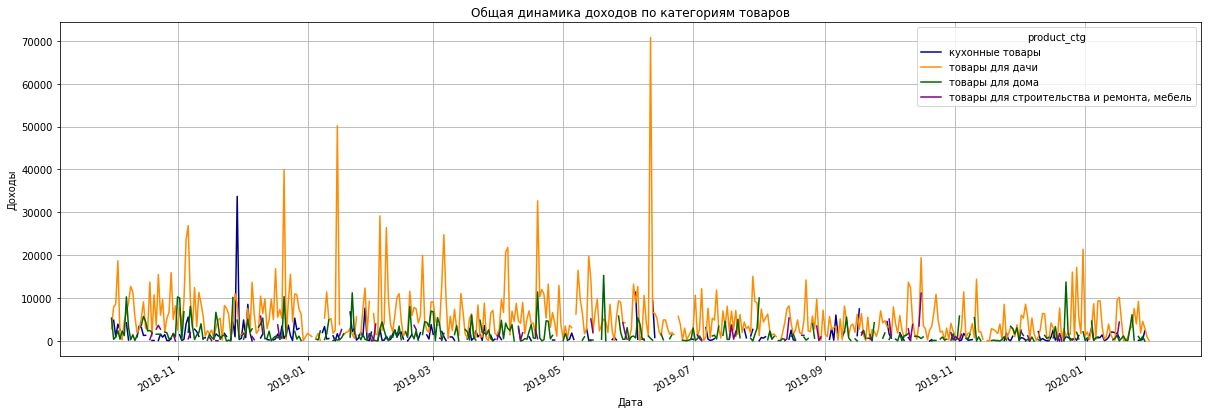

In [65]:
axx = plt.subplot(2, 2, 2)
data.pivot_table(
    index='date',columns='product_ctg',values='total',aggfunc='sum').plot(grid=True, color=["darkblue","darkorange", "darkgreen", "purple"],\
                                                                        figsize=(45, 15), ax=axx)
plt.ylabel('Доходы')
plt.xlabel('Дата')
plt.title('Общая динамика доходов по категориям товаров')
plt.show()

График получается крависвый но не очень наглядный, поэтому вычленим из даты дополнительно год, и посмотрим более тщательно

In [66]:
data['Month_Year'] = data['date'].dt.to_period('M')
data

date                           customer_id  order_id  \
0    2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...         ...                                   ...       ...   
5567 2020-01-30  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5568 2020-01-30  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5569 2020-01-31  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5570 2020-01-31  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5571 2020-01-31  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  \
0       комнатное растение в горшке алое вера, d12, h30         1    142   
1     комнатное растение в горшке кофе арабика, d12,...         1    194   
2                           радермахера d-12 см h-20 см         1    112   
3                      хризолидокарпус лутесценс d-9 см         1    179   
4                        циперус зумула d-12 см h-25 см         1    112   
...                                                 ...       ...    ...   
5567  томата (помидор) черниченский черри № 116 сорт...         2     38   
5568         дендробиум санок анна грин 1 ствол d-12 см         1    869   
5569  подставка для обуви резиновая attribute 80x40 ...         1    354   
5570  тагетис крупноцветковый рассада однолетних цве...         1    128   
5571  вешалка для блузок 41 см красный attribute ahm781         1    104   

      total  month season                                 product_ctg  \
0       142     10  осень                             товары для дачи   
1       194     10  осень                             товары для дачи   
2       112     10  осень                             товары для дома   
3       179     10  осень                             товары для дома   
4       112     10  осень                             товары для дома   
...     ...    ...    ...                                         ...   
5567     76      1   зима                             товары для дачи   
5568    869      1   зима                             товары для дачи   
5569    354      1   зима  товары для строительства и ремонта, мебель   
5570    128      1   зима                             товары для дачи   
5571    104      1   зима                             товары для дома   

     Month_Year  
0       2018-10  
1       2018-10  
2       2018-10  
3       2018-10  
4       2018-10  
...         ...  
5567    2020-01  
5568    2020-01  
5569    2020-01  
5570    2020-01  
5571    2020-01  

[5572 rows x 11 columns]

In [67]:
data.pivot_table(
    index='Month_Year',columns='product_ctg',values='total',aggfunc='sum')

product_ctg  кухонные товары  товары для дачи  товары для дома  \
Month_Year                                                       
2018-10                32932           218557            63757   
2018-11                67738           199357            81981   
2018-12                44614           229334            51170   
2019-01                39597           140335            35346   
2019-02                27116           205548            57195   
2019-03                24698           161415            53926   
2019-04                 7457           241195            56246   
2019-05                10113           169459            33619   
2019-06                25613           182459            20876   
2019-07                16192           158039            36333   
2019-08                10246           121087            25209   
2019-09                37469            98316            24883   
2019-10                10277           135924            17665   
2019-11                11487            81406            29694   
2019-12                16495           138415            33223   
2020-01                22701           109162            24228   

product_ctg  товары для строительства и ремонта, мебель  
Month_Year                                               
2018-10                                           35502  
2018-11                                           10696  
2018-12                                           18260  
2019-01                                           19593  
2019-02                                           16678  
2019-03                                           16797  
2019-04                                           11793  
2019-05                                           18445  
2019-06                                           11230  
2019-07                                           16036  
2019-08                                           24689  
2019-09                                           18812  
2019-10                                           48174  
2019-11                                            6198  
2019-12                                           14743  
2020-01                                           17937

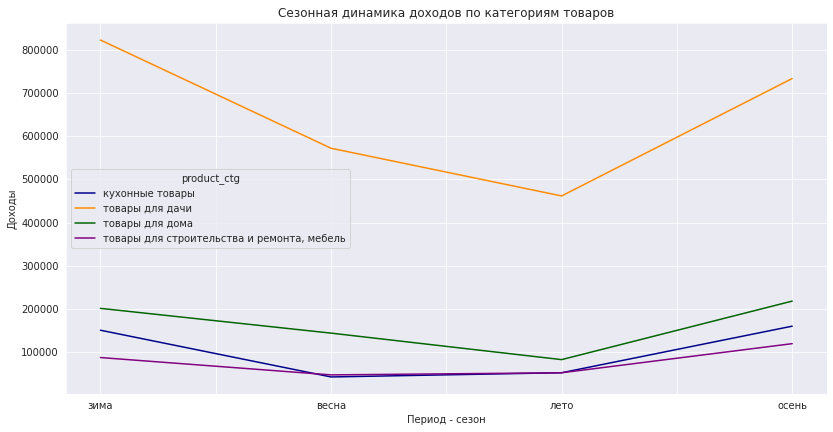

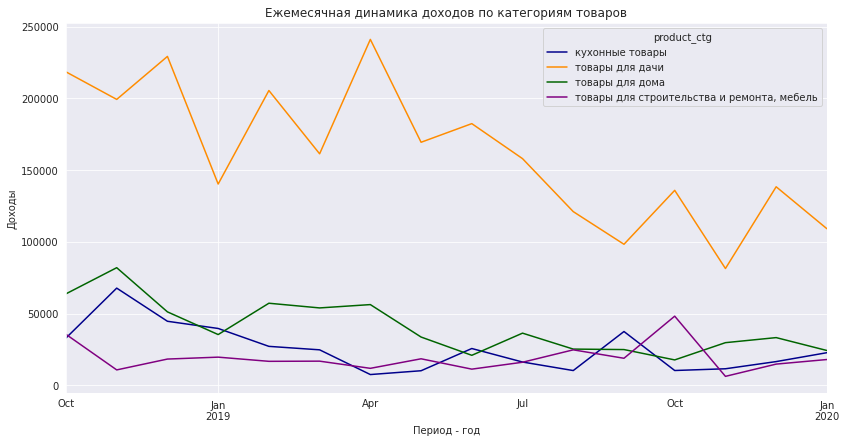

In [68]:
sns.set_style('dark')
plt.grid()
ax1 = plt.subplot(2, 2, 1)
data.pivot_table(index='season', columns='product_ctg', values='total', aggfunc='sum').\
                 reindex(['зима', 'весна', 'лето', 'осень'], axis=0).\
                 plot(grid=True, color=["darkblue","darkorange", "darkgreen", "purple"], figsize=(30, 15), ax=ax1)
plt.ylabel('Доходы')
plt.xlabel('Период - сезон')
plt.title('Сезонная динамика доходов по категориям товаров')
plt.show()

ax2 = plt.subplot(2, 2, 2)
data.pivot_table(
    index='Month_Year',columns='product_ctg',values='total',aggfunc='sum').plot(grid=True, color=["darkblue","darkorange", "darkgreen", "purple"],\
                                                                        figsize=(30, 15), ax=ax2)
plt.ylabel('Доходы')
plt.xlabel('Период - год')
plt.title('Ежемесячная динамика доходов по категориям товаров')
plt.show()

**Что видим**

Товары для дачи зимой продаются намного чаще, у остальных категорий товаров пики приходятся на осень-зиму, а спад на весну-лето. 2019 год получился самым доходным

По кумулятивной выручке самым прибыльным направлением для бизнеса являются товары для дома, чуть меньшую доходность имеют товары для дачи. Отличие между этими категориями заключается в том, что продажа товаров для дачи имеет сезонный характер (с мая доходность этой категории приблизилась к доходности категории товары для дома). Меньшей доходностью обладают две другие категории: чуть более прибыльны кухонные товары; и самым недоходным направлением по кумулятивной выручке являются товары для строительства и ремонта, мебель.

### Разбиение покупателей на группы лояльности с помощью RFM-анализа

In [69]:
# Загрузка данных с RFM-метриками
# Здесь должен быть ваш код для загрузки данных с RFM-метриками
current_date = data['date'].max()  # Текущая дата для расчета Recency
rfm = data.groupby('customer_id').agg({
    'date': lambda x: (current_date - x.max()).days,  # Recency: количество дней с последней покупки
    'order_id': 'nunique',  # Frequency: количество уникальных заказов
    'total': 'sum'  # Monetary: суммарная выручка
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']
# Рассчитываем квантили для каждой RFM-метрики
rfm['RecencyScore'] = pd.qcut(rfm['Recency'], q=4, labels=False, duplicates='drop')
rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'], q=4, labels=False, duplicates='drop')
rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'], q=4, labels=False, duplicates='drop')

# Общий RFM Score
rfm['RFMScore'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) + rfm['MonetaryScore'].astype(str)

# Создаем функцию для категоризации клиентов
def segment_customer(row):
    if row['RecencyScore'] + row['FrequencyScore'] + row['MonetaryScore'] >= 5:
        return 'High Value'
    elif row['RecencyScore'] + row['FrequencyScore'] + row['MonetaryScore'] >= 3:
        return 'Medium Value'
    else:
        return 'Low Value'

# Применяем функцию категоризации к каждой строке
rfm['RFMSegment'] = rfm.apply(segment_customer, axis=1)

# Выводим результаты
rfm

customer_id  Recency  Frequency  Monetary  \
0     000d6849-084e-4d9f-ac03-37174eaf60c4      107          1       555   
1     001cee7f-0b29-4716-b202-0042213ab038      349          1       442   
2     00299f34-5385-4d13-9aea-c80b81658e1b      109          1       914   
3     002d4d3a-4a59-406b-86ec-c3314357e498      369          1      1649   
4     003bbd39-0000-41ff-b7f9-2ddaec152037      124          1      2324   
...                                    ...      ...        ...       ...   
2422  ff601403-b094-4b86-9ac6-264d725b9277       12          2      1739   
2423  ffaeab76-3a8d-49ee-860f-17273b2fc8a2       92          1       397   
2424  ffb5976a-7a4d-460b-95c4-5ffaba31cb24      412          1       389   
2425  ffb80538-3fda-4351-8ea9-9d2bec58bb07      144          1       974   
2426  ffe82299-3f5b-4214-87fe-3d36ecccfac3      101          1       577   

      RecencyScore  FrequencyScore  MonetaryScore RFMScore    RFMSegment  
0                1               0              1      101     Low Value  
1                3               0              1      301  Medium Value  
2                1               0              2      102  Medium Value  
3                3               0              2      302    High Value  
4                1               0              3      103  Medium Value  
...            ...             ...            ...      ...           ...  
2422             0               0              2      002     Low Value  
2423             1               0              0      100     Low Value  
2424             3               0              0      300  Medium Value  
2425             1               0              2      102  Medium Value  
2426             1               0              1      101     Low Value  

[2427 rows x 9 columns]

In [70]:
current_date

Timestamp('2020-01-31 00:00:00')

In [71]:
average_monetary_by_segment = rfm.groupby('RFMSegment')['Monetary'].mean()
print('Среднее значение суммарной выручки', average_monetary_by_segment)

Среднее значение суммарной выручки RFMSegment
High Value      3844.845622
Low Value        527.194906
Medium Value    1652.263303
Name: Monetary, dtype: float64


**Что видим**

Cреднее значение суммарной выручки:
* для **High Value** клиентов - 3844
* для **Low Value** клиентов - 527
* для **Medium Value** клиентов - 1652

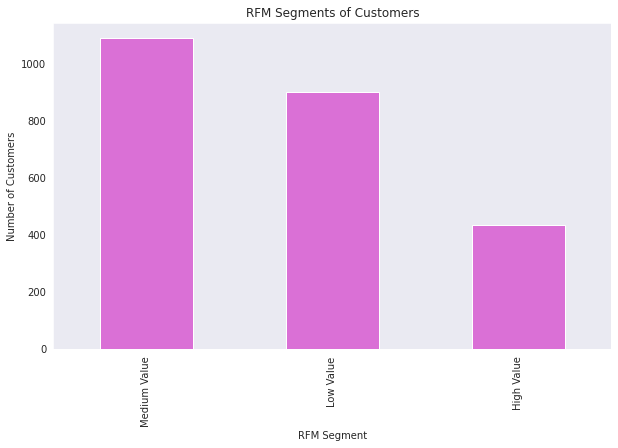

In [72]:
# Подготовка данных для построения графика
segment_counts = rfm['RFMSegment'].value_counts()

# Создание графика
plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar', color='orchid')

# Добавление заголовка и меток на осях
plt.title('RFM Segments of Customers')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')

# Отображение графика
plt.show()

1. Клиенты, отнесенные к категории **"High Value"**, имеют высокий показатель повторных покупок, значительные суммы расходов и обычно приобретают товары/услуги недавно. Они могут быть склонны к частым покупкам и дорогим заказам.

2. Группа **"Medium Value"** состоит из клиентов со средними показателями по RFM-метрикам. Они могут быть активными, но и не такими высокими в своих трат, как клиенты из категории **"High Value"**.

3. **"Low Value"** клиенты имеют наименьший уровень активности и меньшие суммы покупок. Отношения с этой группой клиентов могут потребовать дополнительного внимания и стимулирования для увеличения их активности.

In [73]:
data = data.merge(rfm[['customer_id', 'RFMSegment']], on='customer_id', how='left')
#data

**High Value** клиентов меньше всего, **Low Value** клиентов больше среднего, и **Medium Value** клиентов больше всего

#### Посмотрим на сезонность выделенных сегментов

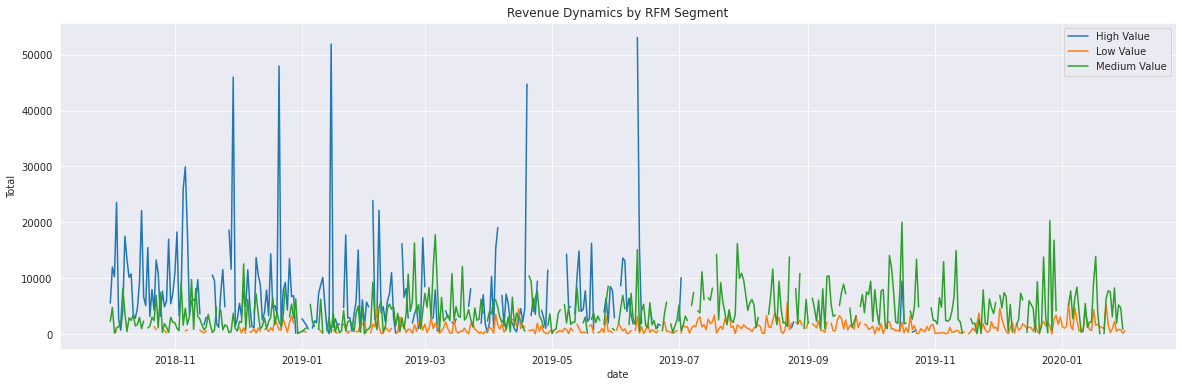

In [74]:
# Создание сводной таблицы для динамики доходности по типам клиентов в RFM анализе
rfm_data = data.pivot_table(index='date', columns='RFMSegment', values='total', aggfunc='sum')

# Построение графика
plt.figure(figsize=(20,6))
for rfm_segment in rfm_data.columns:
 plt.plot(rfm_data.index, rfm_data[rfm_segment], label=rfm_segment)

plt.xlabel('date')
plt.ylabel('Total')
plt.title('Revenue Dynamics by RFM Segment')
plt.legend()
plt.grid(True)
plt.show()

**Что видим**


* High Value сегмент: Этот сегмент клиентов показывает наибольшую динамику выручки с течением времени. Обычно такие клиенты делают больше заказов и приносят больше выручки, поэтому их активность способствует значительным колебаниям в выручке.

* Medium Value сегмент: Динамика выручки в этом сегменте менее выражена по сравнению с сегментом "High Value", но всё же довольно значима. Как правило, клиенты этого сегмента имеют средний уровень активности, их покупки вносят определенный вклад в общую выручку.

* Low Value сегмент: Этот сегмент клиентов характеризуется наименьшей динамикой выручки. Они могут сделать только небольшое количество заказов или приносить меньшую сумму выручки по сравнению с другими сегментами.

In [75]:
rfm_season_s = data.pivot_table(index=['season', 'RFMSegment'], columns='product_ctg', values='total', aggfunc='sum')
#rfm_season_s

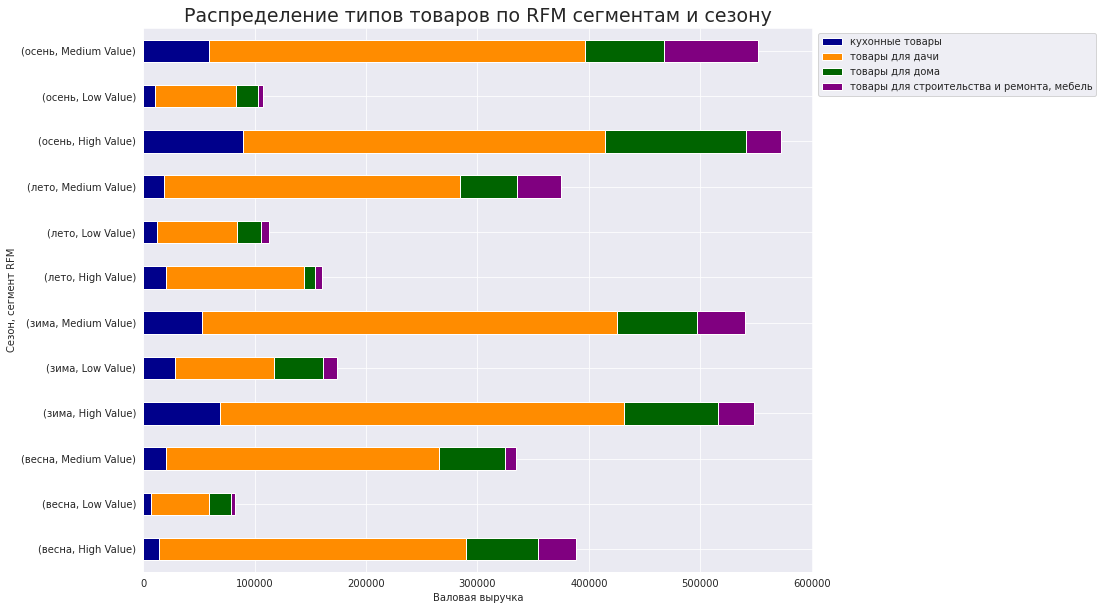

In [76]:
rfm_season_s.plot(kind='barh', stacked = True, color=["darkblue","darkorange", "darkgreen", "purple"],  figsize = (12,10))
sns.set_style('dark')
plt.grid()
plt.xlabel('Валовая выручка') 
plt.ylabel('Сезон, сегмент RFM') 
plt.title('Распределение типов товаров по RFM сегментам и сезону', fontsize=19) 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show();

**Что видим**

Товары для дачи продолжают доминировать среди всех сегментов и всех сезонов

Наибольшую выручку принесли **High Value** клиенты осенью, на втором месте по выручке **Medium Value** клиенты осенью, далее идут **High Value** клиенты зимой и **Medium Value** зимой.

Меньше всего выручки принесли **Low Value** клиенты  весной

In [77]:
rfm_season = data.pivot_table(index=['Month_Year', 'RFMSegment'], columns='product_ctg', values='total', aggfunc='sum')

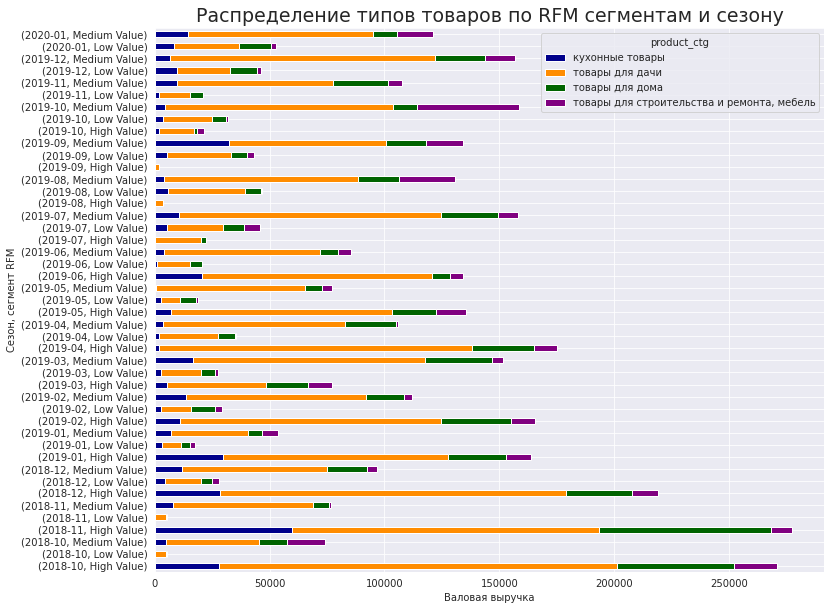

In [78]:
rfm_season.plot(kind='barh', stacked = True, color=["darkblue","darkorange", "darkgreen", "purple"],  figsize = (12,10))
sns.set_style('dark')
plt.grid()
plt.xlabel('Валовая выручка') 
plt.ylabel('Сезон, сегмент RFM') 
plt.title('Распределение типов товаров по RFM сегментам и сезону', fontsize=19) 
plt.show();

**Что видим**

В разрезе месяцев самый удачный для бизнеса месяц оказался ноябрь 2018 года, а обеспечили его **High Value** клиенты

Интересный факт, в сентябре 2019 года **High Value** клиенты принесли меньше всего выручки за рассматриемый период, стоит рассмотреть события за этот период в бизнесе и постараться сделать так, чтобы этого не повторялось(ь.е. поднять интерес **High Value** клиентов в этот период рассылкой маркетинговых предложений, причём в идеале по `товарам для ремонта, мебели` и `кухонным товарам`, так как спрос на них в этот период меньше всего)

Также стоит обратить внимание на август, ноябрь и октябрь, вобщем в конце лета, осени нужно работать над рекламными рассылкми для **High Value** и **Low Value** клиентов

**Посмотрим поближе на товары, преобретаемые разными клиентами**

In [79]:
rfm_season_percentage = rfm_season.div(rfm_season.sum(axis=1), axis=0) * 100
rfm_season_percentage = rfm_season_percentage.reset_index()
#rfm_season_percentage

In [80]:
rfm_season_melted = rfm_season_percentage.melt(id_vars=['Month_Year', 'RFMSegment'], var_name='Product Category', value_name='Percentage')
#rfm_season_melted

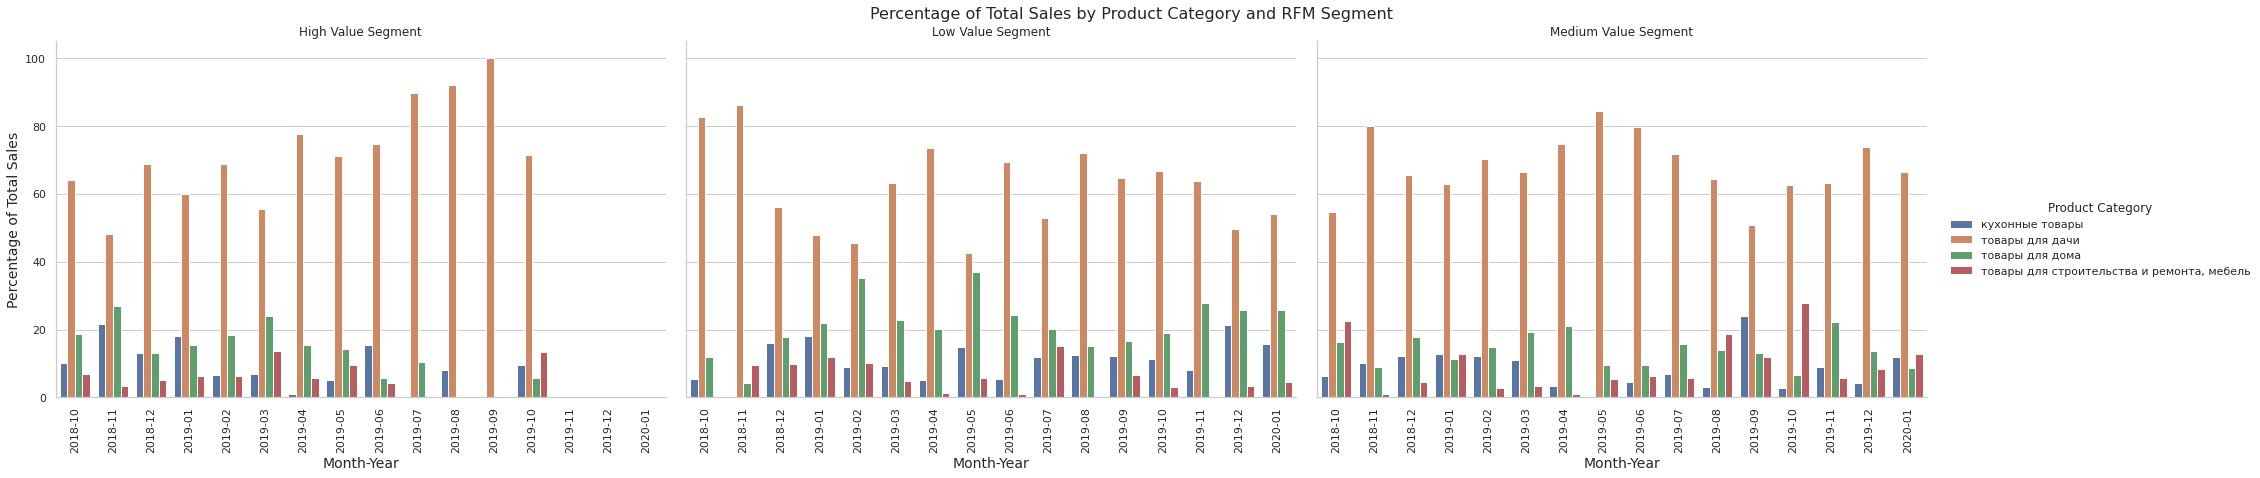

In [81]:
sns.set(style="whitegrid")
g = sns.catplot(
    data=rfm_season_melted, 
    x='Month_Year', y='Percentage', hue='Product Category', 
    col='RFMSegment', kind='bar', height=6, aspect=1.5
)

g.set_titles("{col_name} Segment")
g.set_axis_labels("Month-Year", "Percentage of Total Sales")
g.set_xticklabels(rotation=90)
g.fig.suptitle('Percentage of Total Sales by Product Category and RFM Segment', fontsize=16)
g.fig.subplots_adjust(top=0.9)  

# Увеличение размера шрифта меток осей и легенды
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    

plt.show()

**Что видим**

Дача - любимое место наших клиентов, они регулярно закупаются дачными принадлежностями.

Меньше всенго наши клиенты любят ремонт, мебель и кухни, причём опять же уже писал выше, есть периоды, когда продажи по данным категориям знатно западают, стоит обратить на это внимание

**Посмотрим на эту же статистику в разрезе сезнов**

In [82]:
rfm_season_percentage1 = rfm_season_s.div(rfm_season_s.sum(axis=1), axis=0) * 100
rfm_season_percentage1 = rfm_season_percentage1.reset_index()
#rfm_season_percentage1

In [83]:
rfm_season_melted_1 = rfm_season_percentage1.melt(id_vars=['season', 'RFMSegment'], var_name='Product Category', value_name='Percentage')
#rfm_season_melted_1

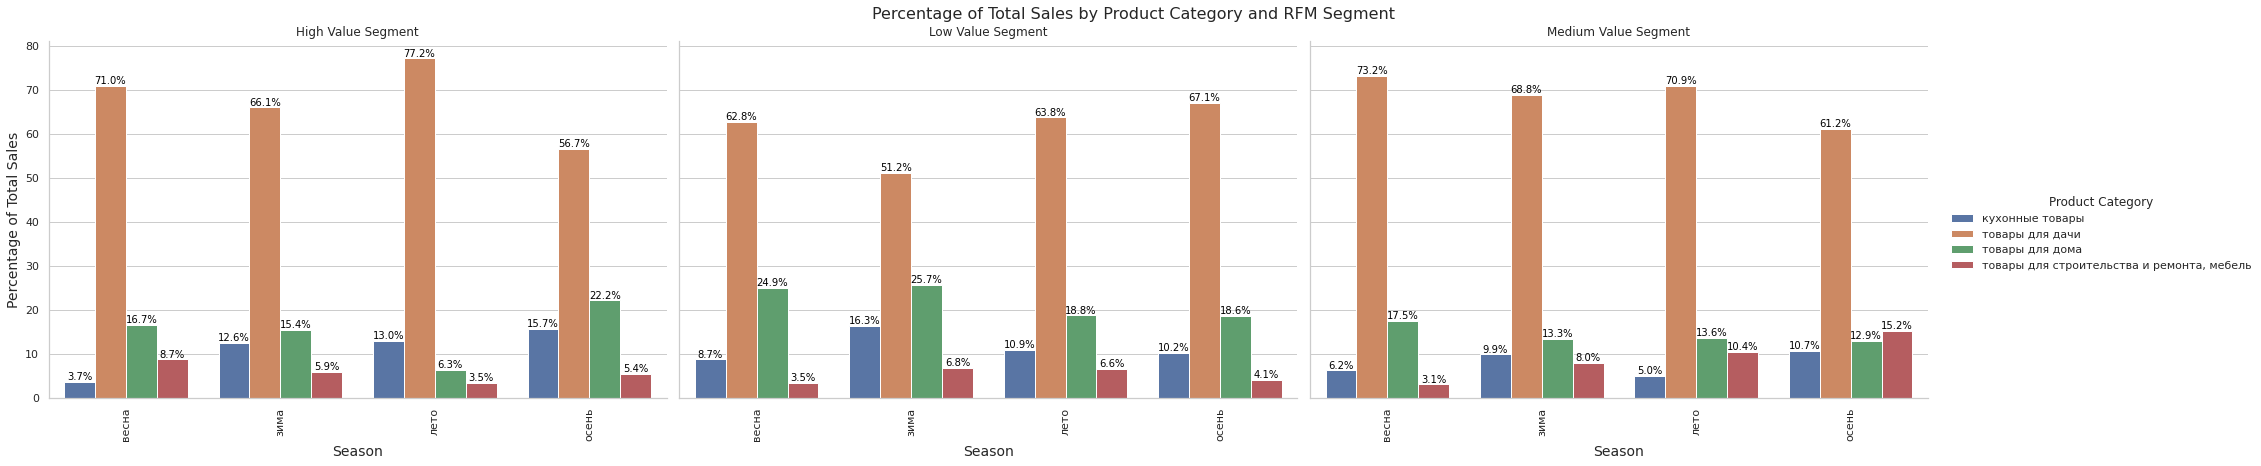

In [84]:
sns.set(style="whitegrid")
g = sns.catplot(
    data=rfm_season_melted_1, 
    x='season', y='Percentage', hue='Product Category', 
    col='RFMSegment', kind='bar', height=6, aspect=1.5
)


g.set_titles("{col_name} Segment")
g.set_axis_labels("Season", "Percentage of Total Sales")
g.set_xticklabels(rotation=90)
g.fig.suptitle('Percentage of Total Sales by Product Category and RFM Segment', fontsize=16)
g.fig.subplots_adjust(top=0.9)  

# Увеличение размера шрифта меток осей и легенды
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
# Добавление числовых значений к столбцам
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.show()

In [85]:
# Создаем сводную таблицу среднего процента по каждому сезону, каждому сегменту клиентов и каждой категории товаров
sr_prcnt = rfm_season_melted_1.pivot_table(
    index=['season', 'RFMSegment'],
    columns='Product Category',
    values='Percentage',
    aggfunc='mean'
)

# Выводим результаты
print("Средний процент от общей выручки по каждому сезону, сегменту клиентов и категории товаров:")
print(sr_prcnt)

Средний процент от общей выручки по каждому сезону, сегменту клиентов и категории товаров:
Product Category     кухонные товары  товары для дачи  товары для дома  \
season RFMSegment                                                        
весна  High Value           3.653945        70.966471        16.651988   
       Low Value            8.748979        62.840004        24.943612   
       Medium Value         6.243019        73.158275        17.522445   
зима   High Value          12.566617        66.093834        15.441666   
       Low Value           16.336762        51.157980        25.658801   
       Medium Value         9.868533        68.836796        13.331852   
лето   High Value          13.015952        77.198514         6.320981   
       Low Value           10.874539        63.775389        18.772694   
       Medium Value         5.043333        70.932837        13.624607   
осень  High Value          15.709783        56.681286        22.192759   
       Low Value     

**Что видим**

Исходя из представленных данных о среднем проценте от общей выручки по каждому сезону, сегменту клиентов и категории товаров, можно сделать следующие выводы:

**Весна:**

Средний процент от общей выручки в сегменте **High Value** составляет примерно **3.7%** для `кухонных товаров`, около **71%** для товаров `для дачи` и примерно **17%** для товаров `для дома`.
В сегменте **Low Value** доля выручки составляет примерно **8.7%** для `кухонных товаров`, около **62.8%** для товаров `для дачи` и около **24.9%** для товаров `для дома`.
В сегменте **Medium Value** доля выручки составляет примерно **6.2%** для `кухонных товаров`, около **73.2%** для товаров `для дачи` и примерно **17.5%** для товаров `для дома`.

**Зима:**

В сегменте **High Value** средний процент составляет примерно **12.6%** для `кухонных товаров`, около **66.1%** для товаров `для дачи` и около **15.4%** для товаров `для дома`.
Для сегмента **Low Value** доля выручки составляет примерно **16.3%** для `кухонных товаров`, около **51.2%** для товаров `для дачи` и около **25.7%** для товаров `для дома`.
В сегменте **Medium Value** доля выручки составляет примерно **9.9%** для `кухонных товаров`, около **68.8%** для товаров `для дачи` и примерно **13.3%** для товаров `для дома`.

**Лето:**

Для сегмента **High Value** средний процент составляет примерно **13.0%** для `кухонных товаров`, около **77.2%** для товаров `для дачи` и примерно **6.3%** для товаров `для дома`.
В сегменте **Low Value** доля выручки составляет примерно **10.9%** для `кухонных товаров`, около **63.8%** для товаров `для дачи` и около **18.8%** для товаров `для дома`.
Для сегмента **Medium Value** доля выручки составляет примерно **5.0%** для `кухонных товаров`, около **70.9%** для товаров `для дачи` и примерно **13.6%** для товаров `для дома`.

**Осень:**

Средний процент от общей выручки в сегменте **High Value** составляет примерно **15.7%** для `кухонных товаров`, около **56.7%** для товаров `для дачи` и около **22.2%** для товаров `для дома`.
В сегменте **Low Value** доля выручки составляет примерно **10.2%** для `кухонных товаров`, около **67.1%** для товаров `для дачи` и около **18.6%** для товаров `для дома`.
В сегменте **Medium Value** доля выручки составляет примерно **10.7%** для `кухонных товаров`, около **61.2%** для товаров `для дачи` и примерно **12.9%** для товаров `для дома`.

Эти выводы могут быть полезны для планирования маркетинговых стратегий и управления ассортиментом товаров в различные сезоны и для разных сегментов клиентов

**Построим круговые дриаграммы для наглядности**

In [86]:
seasons = rfm_season_percentage1['season'].unique()
segments = rfm_season_percentage1['RFMSegment'].unique()

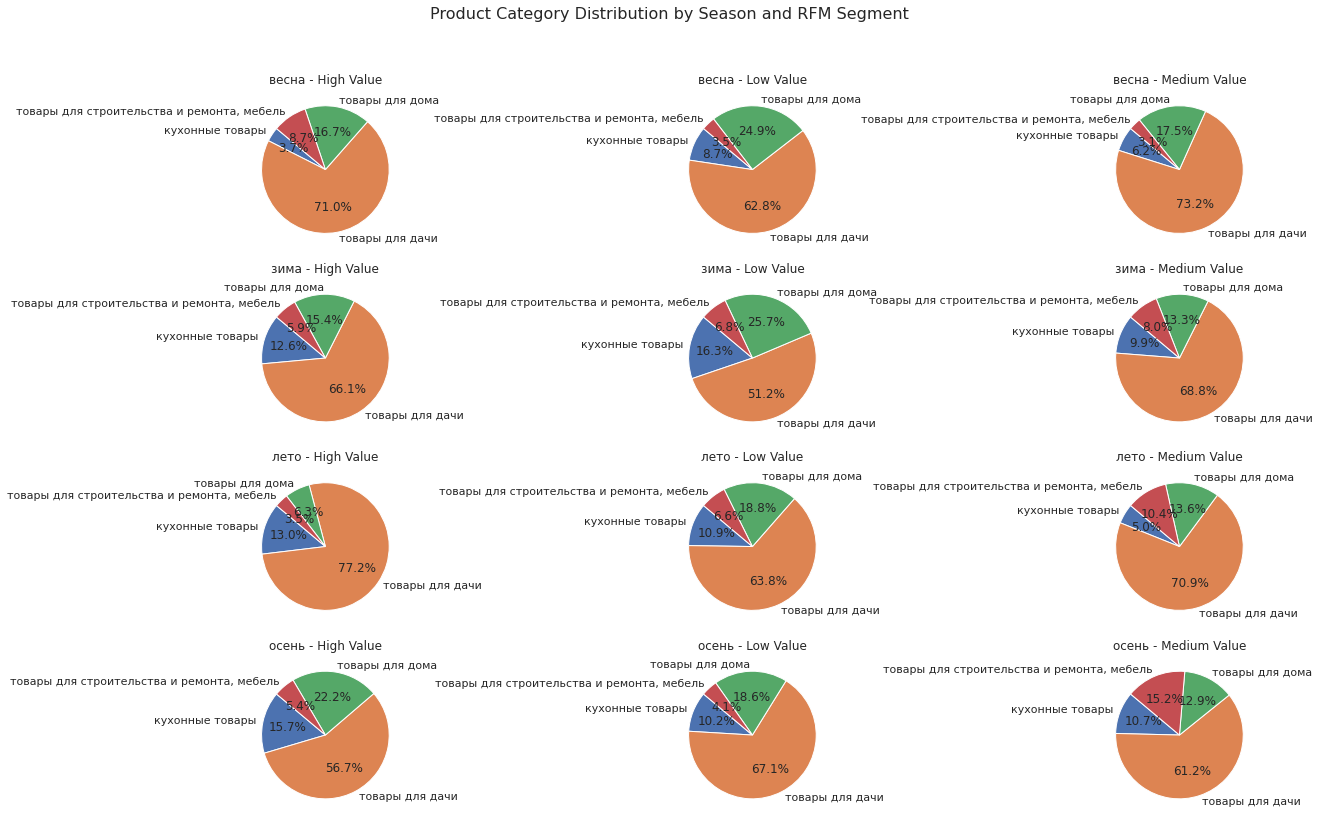

In [87]:
# Рассчитываем процентное соотношение
rfm_season_percentage1 = rfm_season_s.div(rfm_season_s.sum(axis=1), axis=0) * 100
rfm_season_percentage1 = rfm_season_percentage1.reset_index()

# Получение уникальных сезонов и сегментов
seasons = rfm_season_percentage1['season'].unique()
segments = rfm_season_percentage1['RFMSegment'].unique()

# Построение круговых диаграмм для каждой комбинации сезона и сегмента
fig, axes = plt.subplots(len(rfm_season_percentage1['season'].unique()), len(rfm_season_percentage1['RFMSegment'].unique()), figsize=(18, 12))

for i, season in enumerate(rfm_season_percentage1['season'].unique()):
    for j, segment in enumerate(rfm_season_percentage1['RFMSegment'].unique()):
        ax = axes[i, j]
        data1 = rfm_season_melted_1[(rfm_season_melted_1['season'] == season) & (rfm_season_melted_1['RFMSegment'] == segment)]
        if not data.empty:
            ax.pie(data1['Percentage'], labels=data1['Product Category'], autopct='%1.1f%%', startangle=140)
            ax.set_title(f'{season} - {segment}')
        else:
            ax.axis('off')  # Если данных нет, скрываем ось

plt.suptitle('Product Category Distribution by Season and RFM Segment', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##### Исследование розничных и оптовых покупателей (кол-во покупателей, доходность абсолютная и средняя по чеку)

In [88]:
data

date                           customer_id  order_id  \
0    2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...         ...                                   ...       ...   
5567 2020-01-30  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5568 2020-01-30  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5569 2020-01-31  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5570 2020-01-31  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5571 2020-01-31  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  \
0       комнатное растение в горшке алое вера, d12, h30         1    142   
1     комнатное растение в горшке кофе арабика, d12,...         1    194   
2                           радермахера d-12 см h-20 см         1    112   
3                      хризолидокарпус лутесценс d-9 см         1    179   
4                        циперус зумула d-12 см h-25 см         1    112   
...                                                 ...       ...    ...   
5567  томата (помидор) черниченский черри № 116 сорт...         2     38   
5568         дендробиум санок анна грин 1 ствол d-12 см         1    869   
5569  подставка для обуви резиновая attribute 80x40 ...         1    354   
5570  тагетис крупноцветковый рассада однолетних цве...         1    128   
5571  вешалка для блузок 41 см красный attribute ahm781         1    104   

      total  month season                                 product_ctg  \
0       142     10  осень                             товары для дачи   
1       194     10  осень                             товары для дачи   
2       112     10  осень                             товары для дома   
3       179     10  осень                             товары для дома   
4       112     10  осень                             товары для дома   
...     ...    ...    ...                                         ...   
5567     76      1   зима                             товары для дачи   
5568    869      1   зима                             товары для дачи   
5569    354      1   зима  товары для строительства и ремонта, мебель   
5570    128      1   зима                             товары для дачи   
5571    104      1   зима                             товары для дома   

     Month_Year    RFMSegment  
0       2018-10    High Value  
1       2018-10    High Value  
2       2018-10    High Value  
3       2018-10    High Value  
4       2018-10    High Value  
...         ...           ...  
5567    2020-01     Low Value  
5568    2020-01  Medium Value  
5569    2020-01     Low Value  
5570    2020-01     Low Value  
5571    2020-01     Low Value  

[5572 rows x 12 columns]

In [89]:
# сводная таблица по количеству товаров в заказе каждого клиента и его каждого заказа
zakaz_cnt = data.pivot_table(index=['customer_id', 'order_id'], values=['product', 'total'], aggfunc=({'product':'nunique',\
                                                                                                       'total':'sum'}))
zakaz_cnt = zakaz_cnt.sort_values(by='product', ascending=False).reset_index()
zakaz_cnt

customer_id  order_id  product  total
0     d3b9ffea-d143-4747-8d59-74ab843d1ad6     14698       51   2922
1     760aa067-90c3-4794-b7a9-a8831197388b     14715       36   4558
2     2a0acc09-e343-4f92-b5c0-f598ef2b07d4     14688       31   2280
3     3d5fef90-4a65-4a7e-84cf-010eba7b038d     14753       30   1210
4     db77c238-3c80-4032-9e3c-c30a43f4a650     14835       29   3380
...                                    ...       ...      ...    ...
3513  5f6be5bf-7671-4e39-9b3d-b33b035b1e0b     71601        1    134
3514  5f6be5bf-7671-4e39-9b3d-b33b035b1e0b    102868        1    547
3515  5f75c73a-1305-4079-b040-2bcb42085002     68509        1    299
3516  5f7bbd5a-26dc-48ba-bcd8-19560f880fd3     71877        1    749
3517  ffe82299-3f5b-4214-87fe-3d36ecccfac3     73060        1    577

[3518 rows x 4 columns]

In [90]:
# самоконтроль количетсва клиентов в таблице
zakaz_cnt.customer_id.count()

3518

In [91]:
# самоконтроль количетсва уникальных клиентов в таблице
data.customer_id.nunique()

2427

#### Что видим

В таблице получились дубликаты, т.к. один и тот же клиент мог совершать несколько заказов. Чтобы оставить только уникальных клиентов, оставим в датафрейме из задублированных только тех, у которых в заказе больше товаров, чем в других заказах. Например, один и тот же клиент соврешил 3 заказа: 1 заказ - один товар, 2 заказ - два товара, 3 заказ - 3 заказа. Оставим 3 заказ с 3 товарами, а первые два заказа удалим.

Клиентов с количеством товаров хотя бы в одном заказе больше от 3-х и выше будем считать **оптовыми**, а клиентов с количеством товаров не превышающем 3-х товаров в любом из заказов - **розничными**. 

In [92]:
# сводная таблица по количеству товаров в заказе каждого клиента и его каждого заказа
zakazi_cnt = data.pivot_table(index=['customer_id', 'order_id'], values=['product', 'total'], aggfunc=({'product':'nunique',\
                                                                                                       'total':'sum'}))
zakazi_cnt = zakaz_cnt.sort_values(by='product', ascending=False).reset_index()
zakazi_cnt

index                           customer_id  order_id  product  total
0         0  d3b9ffea-d143-4747-8d59-74ab843d1ad6     14698       51   2922
1         1  760aa067-90c3-4794-b7a9-a8831197388b     14715       36   4558
2         2  2a0acc09-e343-4f92-b5c0-f598ef2b07d4     14688       31   2280
3         3  3d5fef90-4a65-4a7e-84cf-010eba7b038d     14753       30   1210
4         4  db77c238-3c80-4032-9e3c-c30a43f4a650     14835       29   3380
...     ...                                   ...       ...      ...    ...
3513   1442  f3dfe740-5c44-45ed-98ee-97835c4769e9     70220        1    134
3514   1443  f3dfe740-5c44-45ed-98ee-97835c4769e9    101934        1     14
3515   1444  f3f12a44-8b82-4850-899f-69130c366f0f     72641        1     29
3516   1445  f420bf6d-9985-47bc-95a7-5c640ad6d001     69842        1     22
3517   3517  ffe82299-3f5b-4214-87fe-3d36ecccfac3     73060        1    577

[3518 rows x 5 columns]

In [93]:
# самоконтроль количетсва клиентов в таблице
zakazi_cnt.customer_id.count()

3518

In [94]:
# самоконтроль количетсва уникальных клиентов в таблице
data.customer_id.nunique()

2427

#### Напишем функция определения принадлежности клиента

In [95]:
def qnt(row):
    if row['product'] < 3:
        return 'Розничный'
    return 'Оптовый'

<font size="2"><b>Применяем функцию к копии датафрейма</b></font><br />

In [96]:
zakazi_cnt1 = zakazi_cnt.copy()
zakazi_cnt1['client_type'] = zakazi_cnt1.apply(qnt, axis=1)
zakazi_cnt1

index                           customer_id  order_id  product  total  \
0         0  d3b9ffea-d143-4747-8d59-74ab843d1ad6     14698       51   2922   
1         1  760aa067-90c3-4794-b7a9-a8831197388b     14715       36   4558   
2         2  2a0acc09-e343-4f92-b5c0-f598ef2b07d4     14688       31   2280   
3         3  3d5fef90-4a65-4a7e-84cf-010eba7b038d     14753       30   1210   
4         4  db77c238-3c80-4032-9e3c-c30a43f4a650     14835       29   3380   
...     ...                                   ...       ...      ...    ...   
3513   1442  f3dfe740-5c44-45ed-98ee-97835c4769e9     70220        1    134   
3514   1443  f3dfe740-5c44-45ed-98ee-97835c4769e9    101934        1     14   
3515   1444  f3f12a44-8b82-4850-899f-69130c366f0f     72641        1     29   
3516   1445  f420bf6d-9985-47bc-95a7-5c640ad6d001     69842        1     22   
3517   3517  ffe82299-3f5b-4214-87fe-3d36ecccfac3     73060        1    577   

     client_type  
0        Оптовый  
1        Оптовый  
2        Оптовый  
3        Оптовый  
4        Оптовый  
...          ...  
3513   Розничный  
3514   Розничный  
3515   Розничный  
3516   Розничный  
3517   Розничный  

[3518 rows x 6 columns]

<font size="2"><b>Теперь преобразуем в датафрейм для построения графика</b></font><br />

In [97]:
cst_type_cnt = zakazi_cnt1.client_type.value_counts().to_frame()
cst_type_cnt

client_type
Розничный         3215
Оптовый            303

#### Визуализируем полученные результат

In [98]:
fig = go.Figure(data=[go.Pie(labels=cst_type_cnt.index, 
                             values=cst_type_cnt['client_type'], 
                             pull = [0.01, 0])]) 
fig.update_layout(title='Соотношение розничных и оптовых покупателей',  
                  width=800, 
                  height=600,
                  annotations=[dict(x=1.1, 
                                    y=1.05,
                                    text='Тип покупателя',
                                    showarrow=False)])
fig.show() 

**Что видим**

Клиенты поделены на оптовых и розничных, еслив  заказе более 3х товаров - оптовый, если менее 3х товаров - розничный. Кол-во розничных клиентов преобладает, оптовых - 8.61%, розничных - 91.4% 

<font size="2"><b>Теперь сравним оптовых и розничных клиентов по доходности</b></font><br />

#### Преобразуем в датафрейм для построения графика

In [99]:
clt_type = zakazi_cnt1.groupby('client_type')['total'].sum().to_frame()
clt_type

total
client_type         
Оптовый       451338
Розничный    3494349

<font size="2"><b>Визуализируем полученные данные</b></font><br />

In [100]:
fig = go.Figure(data=[go.Pie(labels=clt_type.index, 
                             values=clt_type['total'], 
                             pull = [0.01, 0])]) 
fig.update_layout(title='Соотношение валовой выручки компании в зависимости от типа покупателей',  
                  width=800, 
                  height=600,
                  annotations=[dict(x=1.1, 
                                    y=1.05,
                                    text='Тип покупателя',
                                    showarrow=False)])
fig.show() 

**Что видим**

Здесь видим похожую картину, оптовые клиенты, ожидаемо приносят меньше дохода - 11.4%, розничные клиенты приносят 88.6% дохода.

#### Получим средний чек

Объединим полученную таблицу типов клиентов с исходной по `customer_id` и сделаем расчет по каждому клиенту: сумма покупок разделить на количетсво заказов.

In [101]:
zakazi_cnt_new = zakazi_cnt1[['customer_id', 'client_type']]
zakazi_cnt_new

customer_id client_type
0     d3b9ffea-d143-4747-8d59-74ab843d1ad6     Оптовый
1     760aa067-90c3-4794-b7a9-a8831197388b     Оптовый
2     2a0acc09-e343-4f92-b5c0-f598ef2b07d4     Оптовый
3     3d5fef90-4a65-4a7e-84cf-010eba7b038d     Оптовый
4     db77c238-3c80-4032-9e3c-c30a43f4a650     Оптовый
...                                    ...         ...
3513  f3dfe740-5c44-45ed-98ee-97835c4769e9   Розничный
3514  f3dfe740-5c44-45ed-98ee-97835c4769e9   Розничный
3515  f3f12a44-8b82-4850-899f-69130c366f0f   Розничный
3516  f420bf6d-9985-47bc-95a7-5c640ad6d001   Розничный
3517  ffe82299-3f5b-4214-87fe-3d36ecccfac3   Розничный

[3518 rows x 2 columns]

<font size="2"><b>Добавим тип клиета в исходный датафрейм</b></font><br />

In [102]:
data = data.merge(zakazi_cnt_new, how='left', on='customer_id')

In [103]:
data.sample(7)

date                           customer_id  order_id  \
7096  2018-11-12  c971fb21-d54c-4134-938f-16b62ee86d3b     68968   
18780 2019-02-13  c971fb21-d54c-4134-938f-16b62ee86d3b     70240   
25953 2019-10-10  73d1cd35-5e5f-4629-8cf2-3fda829d4e58     72913   
7512  2018-11-20  c971fb21-d54c-4134-938f-16b62ee86d3b     69060   
20160 2019-02-26  c971fb21-d54c-4134-938f-16b62ee86d3b     70461   
11543 2018-12-11  c971fb21-d54c-4134-938f-16b62ee86d3b     69301   
12448 2018-12-14  c971fb21-d54c-4134-938f-16b62ee86d3b     69354   

                                                 product  quantity  price  \
7096                                  фиалка микс d-9 см         2    164   
18780  сумка-тележка хозяйственная rolser jet joy фио...         1   3667   
25953  стремянка colombo factotum 4 ступени стальная ...         1   2849   
7512   салфетка protec textil lino 30х43 см шоколад 6222        12    202   
20160  сушилка для белья напольная ника сб2г 20 м бел...         1    742   
11543  лестница-стремянка примус оцинкованный металл ...         1   1799   
12448  весы напольные механические дельта d-2017 130 ...         1    749   

       total  month season                                 product_ctg  \
7096     328     11  осень                             товары для дома   
18780   3667      2   зима                             товары для дачи   
25953   2849     10  осень  товары для строительства и ремонта, мебель   
7512    2424     11  осень                             товары для дома   
20160    742      2   зима                             товары для дачи   
11543   1799     12   зима  товары для строительства и ремонта, мебель   
12448    749     12   зима                             товары для дачи   

      Month_Year  RFMSegment client_type  
7096     2018-11  High Value   Розничный  
18780    2019-02  High Value   Розничный  
25953    2019-10  High Value   Розничный  
7512     2018-11  High Value   Розничный  
20160    2019-02  High Value   Розничный  
11543    2018-12  High Value   Розничный  
12448    2018-12  High Value   Розничный

<font size="2"><b>Теперь создадим сводную таблицу по количеству заказов и суммарной выручки от них по каждому клиенту</b></font><br />

In [104]:
sum_viruchka = data.pivot_table(index=['client_type', 'customer_id'],values=['order_id', 'total'],\
                             aggfunc={'order_id':'nunique','total':'sum'}).reset_index()
sum_viruchka.rename(columns={'order_id': 'order_cnt'}, inplace=True)
sum_viruchka

client_type                           customer_id  order_cnt  total
0        Оптовый  000d6849-084e-4d9f-ac03-37174eaf60c4          1    555
1        Оптовый  0184f535-b60a-4914-a982-231e3f615206          5  17673
2        Оптовый  01bd5b9a-2b4e-483c-95a3-40b040c392e8          1    408
3        Оптовый  01c31cf3-cdb3-4b90-a2ef-ebe1b9e1fc33          1   5090
4        Оптовый  022ecd2e-bc6c-4e78-938e-b9e4bc526271          1   1214
...          ...                                   ...        ...    ...
2436   Розничный  ff601403-b094-4b86-9ac6-264d725b9277          2   3478
2437   Розничный  ffaeab76-3a8d-49ee-860f-17273b2fc8a2          1    397
2438   Розничный  ffb5976a-7a4d-460b-95c4-5ffaba31cb24          1    389
2439   Розничный  ffb80538-3fda-4351-8ea9-9d2bec58bb07          1    974
2440   Розничный  ffe82299-3f5b-4214-87fe-3d36ecccfac3          1    577

[2441 rows x 4 columns]

<font size="2"><b>Добавим столбец среднего чека</b></font><br />

In [105]:
sum_viruchka['avg_bill'] = round(sum_viruchka['total'] / sum_viruchka['order_cnt'])
sum_viruchka.sample(5)

client_type                           customer_id  order_cnt  total  \
548    Розничный  218f693a-9e88-448f-be59-9e221930cf7f          1    749   
2110   Розничный  d933280e-5372-448f-be44-b269c8bafc2a          1   1900   
129      Оптовый  7d8528bb-623e-477f-a059-efc312b62d29          1   9915   
1328   Розничный  7e138378-b60e-4735-a1e6-72bf000cbda1          1    689   
1114   Розничный  65c965ad-5878-4104-94ad-28c53ac95989          2   1782   

      avg_bill  
548      749.0  
2110    1900.0  
129     9915.0  
1328     689.0  
1114     891.0

<font size="2"><b>Посмотрим на кол-во оптовых и розничных клиентов</b></font><br />

In [106]:
sum_viruchka.client_type.value_counts()

Розничный    2174
Оптовый       267
Name: client_type, dtype: int64

#### Построим диограмму размаха средних чеков для розничных и оптовых клиентов

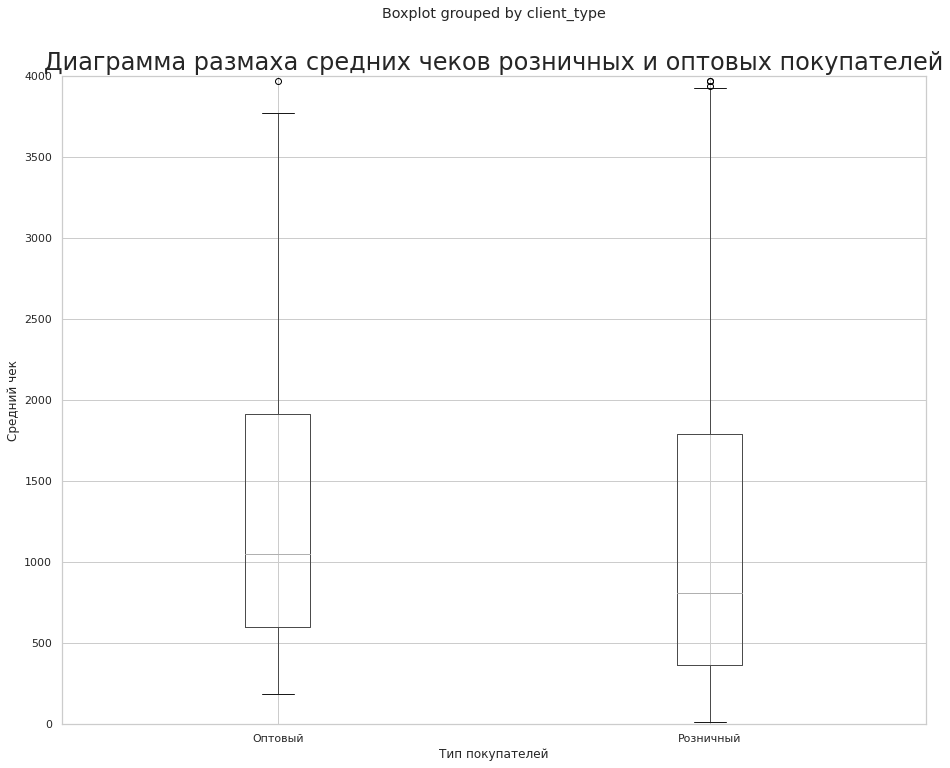

In [107]:
ax = sum_viruchka.boxplot(column='avg_bill', by='client_type', figsize=(15,12));
sns.set_style('dark')
ax.set_ylim(0, 4000);
ax.set_title('Диаграмма размаха средних чеков розничных и оптовых покупателей', fontsize=24);
ax.set_xlabel('Тип покупателей');
ax.set_ylabel('Средний чек');

**Что видим**

 Средний чек оптовых покупателей составил в районе 1000 руб, средний чек розничных - 600 руб.

### Исследование сезонности доходов от групп покупателей

<font size="2"><b>Построим сводную таблицу по доходам от категорий товаров в разрезе сезонности и типа клиентов</b></font><br />

In [108]:
data

date                           customer_id  order_id  \
0     2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1     2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2     2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3     2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4     2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...          ...                                   ...       ...   
27774 2020-01-31  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
27775 2020-01-31  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
27776 2020-01-31  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
27777 2020-01-31  2e460a26-35af-453d-a369-a036e95a40e0    103225   
27778 2020-01-31  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                 product  quantity  price  \
0        комнатное растение в горшке алое вера, d12, h30         1    142   
1      комнатное растение в горшке кофе арабика, d12,...         1    194   
2                            радермахера d-12 см h-20 см         1    112   
3                       хризолидокарпус лутесценс d-9 см         1    179   
4                         циперус зумула d-12 см h-25 см         1    112   
...                                                  ...       ...    ...   
27774  подставка для обуви резиновая attribute 80x40 ...         1    354   
27775  тагетис крупноцветковый рассада однолетних цве...         1    128   
27776  тагетис крупноцветковый рассада однолетних цве...         1    128   
27777  вешалка для блузок 41 см красный attribute ahm781         1    104   
27778  вешалка для блузок 41 см красный attribute ahm781         1    104   

       total  month season                                 product_ctg  \
0        142     10  осень                             товары для дачи   
1        194     10  осень                             товары для дачи   
2        112     10  осень                             товары для дома   
3        179     10  осень                             товары для дома   
4        112     10  осень                             товары для дома   
...      ...    ...    ...                                         ...   
27774    354      1   зима  товары для строительства и ремонта, мебель   
27775    128      1   зима                             товары для дачи   
27776    128      1   зима                             товары для дачи   
27777    104      1   зима                             товары для дома   
27778    104      1   зима                             товары для дома   

      Month_Year  RFMSegment client_type  
0        2018-10  High Value     Оптовый  
1        2018-10  High Value     Оптовый  
2        2018-10  High Value     Оптовый  
3        2018-10  High Value     Оптовый  
4        2018-10  High Value     Оптовый  
...          ...         ...         ...  
27774    2020-01   Low Value   Розничный  
27775    2020-01   Low Value   Розничный  
27776    2020-01   Low Value   Розничный  
27777    2020-01   Low Value   Розничный  
27778    2020-01   Low Value   Розничный  

[27779 rows x 13 columns]

In [109]:
rev_season = data.pivot_table(index=['season', 'client_type'], columns='product_ctg', values='total', aggfunc='sum')
rev_season

product_ctg         кухонные товары  товары для дачи  товары для дома  \
season client_type                                                      
весна  Оптовый                972.0         272329.0           5423.0   
       Розничный            58005.0        1676754.0         308723.0   
зима   Оптовый              13364.0         310271.0          85239.0   
       Розничный           547831.0        9896927.0        2871975.0   
лето   Оптовый                915.0          69145.0            105.0   
       Розничный            83706.0         556028.0         100094.0   
осень  Оптовый              76358.0         329107.0         129381.0   
       Розничный           533502.0        6786698.0        1836000.0   

product_ctg         товары для строительства и ремонта, мебель  
season client_type                                              
весна  Оптовый                                           570.0  
       Розничный                                       63678.0  
зима   Оптовый                                         12116.0  
       Розничный                                      453744.0  
лето   Оптовый                                             NaN  
       Розничный                                       84137.0  
осень  Оптовый                                         39340.0  
       Розничный                                      831853.0

#### Визуализируем полученные результаты

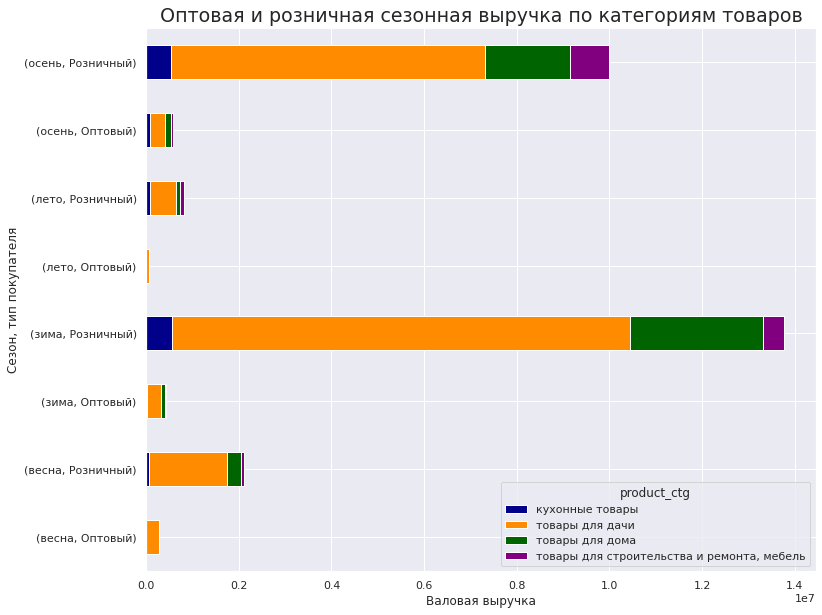

In [110]:
rev_season.plot(kind='barh', stacked = True, color=["darkblue","darkorange", "darkgreen", "purple"],  figsize = (12,10))
sns.set_style('dark')
plt.grid()
plt.xlabel('Валовая выручка') 
plt.ylabel('Сезон, тип покупателя') 
plt.title('Оптовая и розничная сезонная выручка по категориям товаров', fontsize=19) 
plt.show();

<font size="2"><b>Создадим графики динамики доходов по категориям товаров для оптовых и розничных клиентов</b></font><br />

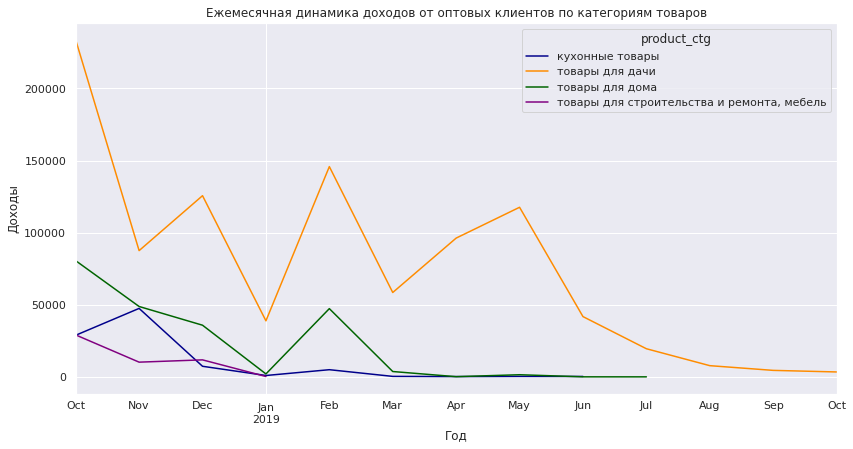

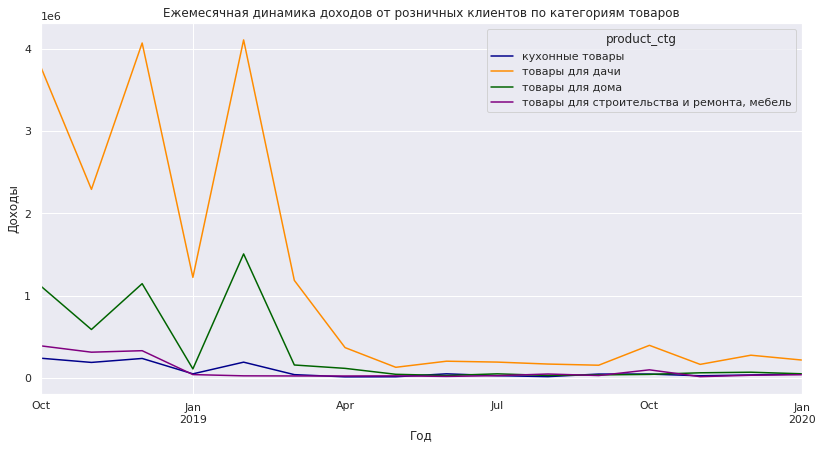

In [111]:
sns.set_style('dark')
plt.grid()
ax1 = plt.subplot(2, 2, 1)
data.query('client_type == "Оптовый"').pivot_table(index='Month_Year', columns='product_ctg', values='total', aggfunc='sum').\
                 plot(grid=True, color=["darkblue","darkorange", "darkgreen", "purple"], figsize=(30, 15), ax=ax1)
plt.ylabel('Доходы')
plt.xlabel('Год')
plt.title('Ежемесячная динамика доходов от оптовых клиентов по категориям товаров')
plt.show()
# вторая ячейка графиков еженемесячных изменений доходов
ax2 = plt.subplot(2, 2, 2, sharex=ax1)
data.query('client_type == "Розничный"').pivot_table(
    index='Month_Year',columns='product_ctg',values='total',aggfunc='sum').plot(grid=True, color=["darkblue","darkorange", "darkgreen", "purple"],\
                                                                        figsize=(30, 15), ax=ax2)
plt.ylabel('Доходы')
plt.xlabel('Год')
plt.title('Ежемесячная динамика доходов от розничных клиентов по категориям товаров')
plt.show()

**Что видим**

По графикам видно, что как у оптовых, так и у рознечных клиентов на первом месте по интересам стоят товары для дачи. Для оптовых клиетов пики приходятся на 5ый и 10ый месяц, для розничных клиентов пик приходится на 12 месяц. Остальные категории товаров оптовики покупают нерегулярно - в основном конец осени и зима. Розничные покупатели задают спрос на товары в течение всего года - по характеру покупок они повторяют характер покупок всех клиентов, что рассматривался выше без учета типа клиентов.

## Проверка гипотез

**Гипотеза 1:** Средний чек по типам клиентов отличается/не отличается

**H0:** Сриедний чек по типам клиентов отличается

**H1:** Сриедний чек по типам клиентов не отличается

In [112]:
#data

In [113]:
product_clusters = data.pivot_table(
    index=['order_id','RFMSegment'], values=['product_ctg', 'total'], aggfunc={'product_ctg':'nunique', 'total':'sum'}).reset_index()
product_clusters['avg_bill'] = product_clusters['total'] / product_clusters['product_ctg']

In [114]:
sam_check_0 = product_clusters[product_clusters['RFMSegment'] == 'High Value']['avg_bill']
sam_check_1 = product_clusters[product_clusters['RFMSegment'] == 'Medium Value']['avg_bill']
sam_check_2 = product_clusters[product_clusters['RFMSegment'] == 'Low Value']['avg_bill']

In [115]:
# Проверка нормальности распределения для выборки sam_check_0
alpha = 0.05 
statistic_0, p_value_0 = stats.shapiro(sam_check_0)
print('Тест Шапиро-Уилка для выборки sam_check_0:')
print('Статистика теста:', statistic_0)
print('p-значение:', p_value_0)
if p_value_0 > alpha:
    print('Выборка sam_check_0 имеет нормальное распределение')
else:
    print('Выборка sam_check_0 не имеет нормального распределения')
# Проверка нормальности распределения для выборки sam_check_1
statistic_1, p_value_1 = stats.shapiro(sam_check_1)
print('\nТест Шапиро-Уилка для выборки sam_check_1:')
print('Статистика теста:', statistic_1)
print('p-значение:', p_value_1)
if p_value_1 > alpha:
    print('Выборка sam_check_1 имеет нормальное распределение')
else:
    print('Выборка sam_check_1 не имеет нормального распределения')
    
statistic_2, p_value_2 = stats.shapiro(sam_check_2)
print('\nТест Шапиро-Уилка для выборки sam_check_2:')
print('Статистика теста:', statistic_2)
print('p-значение:', p_value_2)
if p_value_2 > alpha:
    print('Выборка sam_check_2 имеет нормальное распределение')
else:
    print('Выборка sam_check_2 не имеет нормального распределения')

Тест Шапиро-Уилка для выборки sam_check_0:
Статистика теста: 0.40274542570114136
p-значение: 9.360673741689778e-43
Выборка sam_check_0 не имеет нормального распределения

Тест Шапиро-Уилка для выборки sam_check_1:
Статистика теста: 0.6608008742332458
p-значение: 0.0
Выборка sam_check_1 не имеет нормального распределения

Тест Шапиро-Уилка для выборки sam_check_2:
Статистика теста: 0.7551957368850708
p-значение: 3.877673110479634e-41
Выборка sam_check_2 не имеет нормального распределения


Соответственно t-test использовать не можем

**Проведём множественную проверку гипотез**

Для множественной проверки этой гипотезы можно использовать анализ дисперсии (ANOVA), так как он позволяет определить, есть ли статистически значимые различия между средними значениями нескольких групп. Затем применяется коррекция уровня значимости для контроля вероятности ложноположительных результатов.

Метод Холма - это один из методов, который корректирует уровень значимости таким образом, чтобы контролировать вероятность совершения хотя бы одной ошибки первого рода при множественном тестировании гипотез. Он менее консервативен, чем метод Бонферрони, но все еще обеспечивает контроль над уровнем ложноположительных результатов.

In [116]:
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests

In [117]:
statistic, p_value = f_oneway(sam_check_0, sam_check_1, sam_check_2)

In [118]:
print("P-value до коррекции:", p_value)

P-value до коррекции: 2.3399013219481307e-75


In [119]:
# Множественная коррекция методом Холма
alpha = 0.05
p_values = [p_value]
reject, p_corrected, _, _ = multipletests(p_values, alpha=alpha, method='holm')

# Печать скорректированных значений p-value
print("Скорректированный p-value:", p_corrected)
# Проверка, была ли отвергнута нулевая гипотеза для каждой гипотезы
if reject[0]:
    print("Нулевая гипотеза отвергнута: Средний чек отличается в зависимости от типа клиента")
else:
    print("Нулевая гипотеза не отвергнута: Средний чек не отличается в зависимости от типа клиента")


Скорректированный p-value: [2.33990132e-75]
Нулевая гипотеза отвергнута: Средний чек отличается в зависимости от типа клиента


**Что видим**

Полученное скорректированное значение p-value очень близко к нулю (1.09665117e-272), что свидетельствует о том, что мы имеем крайне сильное статистическое доказательство в пользу того, что средний чек действительно отличается в зависимости от типа клиента. На уровне значимости 0.05 нулевая гипотеза отвергнута.

Таким образом, можем сделать вывод о том, что средний чек различается в зависимости от типа клиента.

**Что видим**

Тест Краскела-Уоллиса позволяет определить, есть ли статистически значимые различия между средними чеками различных типов клиентов. Полученный результат, указывающий на статистическую значимость различий, означает, что различия в среднем чеке между типами клиентов статистически значимы

**Гипотеза 2:** Помесячная выручка от оптовых клиентов выше, чем выручка от розничных клиентов

**H0:** Помесячная выручка от оптовых покупателей равна помесячной выручке от розничных пользователей.

**H1:** Помесячная выручка от оптовых покупателей выше, чем от розничных покупателей.

<font size="2"><b>Помесячная группировка суммарного дохода от оптовых покупателей</b></font><br />

In [120]:
df_opt = data.query('client_type == "Оптовый"').groupby(['month', 'customer_id']).agg({'total':'sum'})
#df_opt

<font size="2"><b>Помесячная группировка суммарного дохода от розничных покупателей</b></font><br />

In [121]:
df_rzn = data.query('client_type == "Розничный"').groupby(['month', 'customer_id']).agg({'total':'sum'})
#df_rzn

In [122]:
alpha = 0.05 
statistic_0, p_value_0 = stats.shapiro(df_opt)
print('Тест Шапиро-Уилка для выборки df_opt:')
print('Статистика теста:', statistic_0)
print('p-значение:', p_value_0)
if p_value_0 > alpha:
    print('Выборка df_opt имеет нормальное распределение')
else:
    print('Выборка df_opt не имеет нормального распределения')
# Проверка нормальности распределения для выборки sam_check_1
statistic_1, p_value_1 = stats.shapiro(df_rzn)
print('\nТест Шапиро-Уилка для выборки df_rzn:')
print('Статистика теста:', statistic_1)
print('p-значение:', p_value_1)
if p_value_1 > alpha:
    print('Выборка df_rzn имеет нормальное распределение')
else:
    print('Выборка df_rzn не имеет нормального распределения')
    

Тест Шапиро-Уилка для выборки df_opt:
Статистика теста: 0.18176323175430298
p-значение: 1.32451819816076e-33
Выборка df_opt не имеет нормального распределения

Тест Шапиро-Уилка для выборки df_rzn:
Статистика теста: 0.02391427755355835
p-значение: 0.0
Выборка df_rzn не имеет нормального распределения


Соответственно и здесь не можем использовать t-test

In [123]:
from scipy.stats import mannwhitneyu

# Применение U-теста Манна-Уитни
statistic, p_value = mannwhitneyu(df_opt, df_rzn, alternative='greater')

# Вывод результатов
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Нулевая гипотеза отвергается: Помесячная выручка от оптовых клиентов выше, чем от розничных клиентов")
else:
    print("Нулевая гипотеза не отвергается: Помесячная выручка от оптовых клиентов равна или ниже, чем от розничных клиентов")

P-value: [1.53626503e-12]
Нулевая гипотеза отвергается: Помесячная выручка от оптовых клиентов выше, чем от розничных клиентов


**Что видим**

Из полученного значения `p-value`, равного **1.53626503e-12** (что близко к нулю), следует, что мы имеем очень сильное статистическое доказательство в пользу того, что помесячная выручка от оптовых клиентов действительно выше, чем от розничных клиентов. На уровне значимости 0.05 нулевая гипотеза отвергается.

Таким образом, на основе проведенного анализа мы можем с уверенностью сказать, что средняя помесячная выручка от оптовых клиентов статистически значимо выше, чем от розничных клиентов.

## Общий вывод 

**Проделанная работа**

**Предобработка**

Выполнена предобработка данных в исходных данных: удалены явные и неявные дубликаты. Транзакции магазина предоставлены за период 01.10.2018-31.01.2020 без пропущенных значений. В датасете содержатся сведения о покупках по 3519 заказам и 2428 клиентам.

**Анализ данных позволил сделать следующие выводы.**

* Разброс по ценам товаров достаточно большой (стандартное отклонение около 870 ден.ед.), и есть "всплески" (максимум составляет 14 917 ден.ед.). При этом большинство клиентов покупает товар в пределах до 400 ден.ед. (минимальная стоимость равна 9 ден.ед., первый квартиль - 101 ден.ед., медиана составляет 135 ден.ед., а третий квартиль - 404 ден.ед.). Средняя стоимость единицы купленного товара отличается от медианной, что связано с "всплесками" ("выбросами"), и составляет около 460 ден.ед. Отметим, что основное число покупок приходится на цену товара до определённого значения. Свыше него имеются отдельные "выбросы".
**То есть очень дорогой товар покупают не так часто и не так много, как дешёвый.**

* Разброс по выручке за проданный товар тоже достаточно большой (стандартное отклонение составило около 1 355 ден.ед.), и есть "всплески" (максимум составляет 47 385 ден.ед.). При этом большинство клиентов тратит на покупку до 600 ден.ед. (минимальная стоимость покупки равна 9 ден.ед., первый квартиль - 120 ден.ед., медиана составляет 157 ден.ед., а третий квартиль - 599 ден.ед.). Средняя стоимость покупки отличается от медианной, что связано с "всплесками" ("выбросами"), и составляет около 604 ден.ед.
**То есть профиль потребителя следует составлять не только, исходя из категории товара, но и из выручки (доходности, которую покупка товара приносит интернет-магазину).**
* Средний чек в магазине составляет 2000 руб, среднее число товаров в заказе - 3 шт.

**Существет 4 основных товарных групп:**

    * товары для дачи: это рассада, уличные урны, черенки, тележки, семена и т.д.;
    * товары для дома: это комнатные растения, гладильные доски, вешалки, ванные принадлежности, полотенца и т.д.;
    * кухонные товары: это посуда, губки, скатерти;
    * товары для строительства и ремонта, мебель: это полки, фурнитурные принадлежности, стремянки

**Проведено условное разбиение покупателей на оптовых и розничных. Клиентов с количеством товаров хотя бы в одном заказе от 3-х и выше будем считать оптовыми, а клиентов с количеством товаров не превышающем 3-х товаров в любом из заказов - розничными:**

    * соотошение розничных к оптовым как 9:1.
    * розничные покупатели приносят 86% выручки, а оптовые 14%
    * средний чек оптовых покупателей составил в районе 1000 руб, средний чек розничных - 600 руб.
    
**Были выведены 3 сегмента клиентов**
**По сегментам клиентов, полученным в RFM анализе можно сделать следущие выводы**:

1.**Кластер High (Высокие показатели):** Клиенты в этой группе являются самыми ценными и активными. Рекомендуется уделить им особое внимание, предлагая персонализированные предложения и премии за лояльность.<br/><br/>2. **Кластер Medium (Средние показатели):** Эти клиенты имеют средние значения RFM-метрик. Хотя они активны, существует потенциал для увеличения их активности. Рекомендуется стимулировать их дополнительными бонусами или предложениями.<br/><br/>3. **Кластер Low (Низкие показатели):** Клиенты в этой группе нуждаются во внимании и стимулировании. Рекомендуется привлечь их внимание с помощью индивидуальных предложений, участия в программе лояльности или дополнительными льготами.<br/><br/>Исходя из этих рекомендаций, вы сможете разработать более целенаправленные и эффективные маркетинговые стратегии для каждого кластера клиентов в вашей компании. Пожалуйста, запустите данный код для добавления описаний и рекомендаций к кластерам на основе результатов RFM-анализа и проанализируйте выходные данные для формирования дальнейших стратегий взаимодействия с клиентами.

    
**Итоги рассмотрения сезонности по сегментам клиентов**

Исходя из представленных данных о среднем проценте от общей выручки по каждому сезону, сегменту клиентов и категории товаров, можно сделать следующие выводы:

**Весна:**

Средний процент от общей выручки в сегменте **High Value** составляет примерно **3.7%** для `кухонных товаров`, около **71%** для товаров `для дачи` и примерно **17%** для товаров `для дома`.
В сегменте **Low Value** доля выручки составляет примерно **8.7%** для `кухонных товаров`, около **62.8%** для товаров `для дачи` и около **24.9%** для товаров `для дома`.
В сегменте **Medium Value** доля выручки составляет примерно **6.2%** для `кухонных товаров`, около **73.2%** для товаров `для дачи` и примерно **17.5%** для товаров `для дома`.

**Зима:**

В сегменте **High Value** средний процент составляет примерно **12.6%** для `кухонных товаров`, около **66.1%** для товаров `для дачи` и около **15.4%** для товаров `для дома`.
Для сегмента **Low Value** доля выручки составляет примерно **16.3%** для `кухонных товаров`, около **51.2%** для товаров `для дачи` и около **25.7%** для товаров `для дома`.
В сегменте **Medium Value** доля выручки составляет примерно **9.9%** для `кухонных товаров`, около **68.8%** для товаров `для дачи` и примерно **13.3%** для товаров `для дома`.

**Лето:**

Для сегмента **High Value** средний процент составляет примерно **13.0%** для `кухонных товаров`, около **77.2%** для товаров `для дачи` и примерно **6.3%** для товаров `для дома`.
В сегменте **Low Value** доля выручки составляет примерно **10.9%** для `кухонных товаров`, около **63.8%** для товаров `для дачи` и около **18.8%** для товаров `для дома`.
Для сегмента **Medium Value** доля выручки составляет примерно **5.0%** для `кухонных товаров`, около **70.9%** для товаров `для дачи` и примерно **13.6%** для товаров `для дома`.

**Осень:**

Средний процент от общей выручки в сегменте **High Value** составляет примерно **15.7%** для `кухонных товаров`, около **56.7%** для товаров `для дачи` и около **22.2%** для товаров `для дома`.
В сегменте **Low Value** доля выручки составляет примерно **10.2%** для `кухонных товаров`, около **67.1%** для товаров `для дачи` и около **18.6%** для товаров `для дома`.
В сегменте **Medium Value** доля выручки составляет примерно **10.7%** для `кухонных товаров`, около **61.2%** для товаров `для дачи` и примерно **12.9%** для товаров `для дома`.

Эти выводы могут быть полезны для планирования маркетинговых стратегий и управления ассортиментом товаров в различные сезоны и для разных сегментов клиентов
    
**На основании обработанных данных проведены 2 гипотезы:**
* **Гипотеза 1**: Сриедний чек по типам клиентов отличается/не отличается
* **Гипотеза 2**: Помесячная выручка от оптовых клиентов выше, чем выручка от розничных клиентов

**Итогом первой гипотезы**:

Cреднее значение суммарной выручки:

* для High Value клиентов - 3844
* для Low Value клиентов - 527
* для Medium Value клиентов - 1652

Полученное скорректированное значение p-value очень близко к нулю (1.09665117e-272), что свидетельствует о том, что мы имеем крайне сильное статистическое доказательство в пользу того, что средний чек действительно отличается в зависимости от типа клиента. На уровне значимости 0.05 нулевая гипотеза отвергнута.

Таким образом, можем сделать вывод о том, что средний чек различается в зависимости от типа клиента.

**Итоги второй гипотезы**

Из полученного значения p-value, равного 1.53626503e-12 (что близко к нулю), следует, что мы имеем очень сильное статистическое доказательство в пользу того, что помесячная выручка от оптовых клиентов действительно выше, чем от розничных клиентов. На уровне значимости 0.05 нулевая гипотеза отвергается.

Таким образом, на основе проведенного анализа мы можем с уверенностью сказать, что средняя помесячная выручка от оптовых клиентов статистически значимо выше, чем от розничных клиентов.

**Рекомендации**

Исходя из проведенного анализа данных и результатов гипотез, можно сформулировать следующие рекомендации для компании **"Пока все ещё тут"**:

**Персонализированный подход к клиентам:**

Имея информацию о сегментах клиентов, компания может настроить персонализированные маркетинговые кампании для каждого сегмента. Например, для клиентов из сегмента **High Value** можно предложить эксклюзивные акции и скидки, а для сегмента **Low Value** - специальные предложения для привлечения их внимания и увеличения активности.

**Улучшение сервиса для оптовых клиентов:**

Учитывая, что оптовые клиенты приносят значительную часть выручки, компания должна обеспечить высокий уровень обслуживания для этой категории клиентов. Это может включать в себя быструю обработку заказов, гибкую систему скидок и индивидуальный подход к каждому оптовому клиенту.

**Оптимизация ассортимента товаров:**

Изучив данные о категориях товаров, которые наиболее востребованы в разные сезоны и сегменты клиентов, компания может оптимизировать свой ассортимент и сосредоточить усилия на продвижении наиболее популярных товаров. Например, в летний период усиленно продвигать товары для дачи и сада, а в зимний период - товары для дома и ремонта.

**Улучшение пользовательского опыта:**

Для удержания клиентов и привлечения новых компания должна постоянно работать над улучшением пользовательского опыта. Это включает в себя удобство навигации по сайту, быстрый и удобный процесс заказа, а также дружелюбное обслуживание клиентов.

**Продолжение анализа данных:**

Анализ данных является непрерывным процессом, и компания должна продолжать мониторить и анализировать свои данные, чтобы выявлять новые тенденции и возможности для улучшения бизнеса. Это поможет компании быть гибкой и адаптироваться к изменяющимся потребностям рынка и клиентов.


Применение этих рекомендаций поможет компании **"Пока все ещё тут"** укрепить свои позиции на рынке, привлечь новых клиентов и увеличить выручку.В рамках категорий покупаемых товаров периодически рекомендовать покупателю товар, имеющий высокую и очень высокую доходность для магазина.


## Доп материалы

[Презентация](https://drive.google.com/file/d/1mvhwFJcWRWReWhRggN519DNvUWsYm4Hq/view?usp=sharing)